# Climate Project

## Idea

Make predictions concerning climate change variables using two models, one less desirable (curve fitting) and the other more suitable (LSTM neural network), so that we compare both behaviour. Then the same will be done with essential food, and a pearson correlation will be established bewteen the  two quantities.

## Sources

Data concerning climate trends: https://science.nasa.gov/climate-change/ 

Data concerning food prices : https://www.fao.org/worldfoodsituation/foodpricesindex/en/

In [3]:
#import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import matplotlib.colors as mcolors
import matplotlib.cm as cm

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers



## Load Data

In [5]:
#Specify folder location
folder=r'Assets'

#define a function that gets the datasets
def files(folder):
    namefiles = os.listdir(folder) #list filenames inside folder
    pathfiles = []
    for name in namefiles:
        path = folder+f'\{name}'
        pathfiles.append(path)
    return (np.array(pathfiles)[1:])

#check if it is returning all datasets intended
print(files(folder))


['Assets\\ch4_mm_gl.txt' 'Assets\\co2_mm_mlo.txt' 'Assets\\coffee.csv'
 'Assets\\food_price_indices_data.csv' 'Assets\\Land_Ocean Temp.txt'
 'Assets\\ocean_warming.txt']


<string>:9: SyntaxWarning: invalid escape sequence '\{'
<>:9: SyntaxWarning: invalid escape sequence '\{'
<string>:9: SyntaxWarning: invalid escape sequence '\{'
<>:9: SyntaxWarning: invalid escape sequence '\{'
C:\Users\User\AppData\Local\Temp\ipykernel_17972\1214682507.py:9: SyntaxWarning: invalid escape sequence '\{'
  path = folder+f'\{name}'


In [7]:
#specify the pathfiles
pathfiles= files(folder)

#read datasets and customize for each skiprows conditions
df_ch4=pd.read_fwf(pathfiles[0],  skiprows=47) #methan concentration dataset
df_co2=pd.read_fwf(pathfiles[1], skiprows=41) # carbon dioxide concentration dataset
df_T=pd.read_csv(pathfiles[4], sep=r'\s+', skiprows=3) #global temperatures dataset 
df_o=pd.read_fwf(pathfiles[5]) #ocean warming dataset
df_T

Year  No_Smoothing  Lowess(5)
0    ----------------------------           NaN        NaN
1                            1880         -0.18      -0.11
2                            1881         -0.10      -0.14
3                            1882         -0.12      -0.18
4                            1883         -0.18      -0.21
..                            ...           ...        ...
141                          2020          1.01       0.97
142                          2021          0.85       1.02
143                          2022          0.89       1.08
144                          2023          1.17       1.13
145                          2024          1.28       1.19

[146 rows x 3 columns]

In [9]:
#clean data

# ------------------------------------------------------------------------------------------------------------------------------------------------
df_ch4 = df_ch4.drop(columns=['#'])

# Year – The year of measurement (e.g., 1983).
# Month – The month of measurement (e.g., 5 for May).
# Decimal Date – The date represented as a decimal value (e.g., 1983.375 for mid-May).
# Monthly Average CH₄ (ppb) – The average atmospheric methane concentration for the month, measured in parts per billion (ppb).
# Average Uncertainty (ppb) – The methane concentration with seasonal variations removed.
# Trend (ppb) – The smoothed long-term trend of methane concentration, filtering out short-term fluctuations and seasonal variations. This represents the underlying increase or decrease in methane levels over time.
# Trend_unc (ppb) – The uncertainty associated with the trend value, indicating the confidence level in the computed trend. A higher uncertainty means less confidence in the estimated trend..

df_ch4.columns=['Year',
                'Month',
                'Decimal Date',
                'Monthly Average CH₄ (ppb)',
                'Average Uncertainty (ppb)',
                'Trend (ppb)',
                'Trend Uncetainty (ppb)']

# We have several data for each year, so  a mean was done and group by the year value clause was implemented


# ------------------------------------------------------------------------------------------------------------------------------------------------

# Year - The year of measurement 
# Month - The month of measurement 
# Decimal Date - A decimal representation of the date 
# Monthly Average CO₂ (ppm) - The average CO₂ concentration for the month 
# De-seasonalized CO₂ (ppm) - The CO₂ concentration with seasonal variation removed 
# Number of Days - The number of days used to compute the monthly mean (negative values indicate missing data).
# Standard Deviation - The standard deviation of daily CO₂ values in the month (negative values indicate missing data).
# Uncertainty of Monthly Mean - The uncertainty in the monthly mean CO₂ concentration (negative values indicate missing data).

df_co2.columns=['Year',
                'Month',
                'Decimal Date',
                'Monthly Average CO₂ (ppm)',
                'De-seasonalized CO₂ (ppm)',
                'Number of Days',
                'Standard Deviation',
                'Uncertainty of Monthly Mean' ]

# We have several data for each year, so  a mean was done and group by the year value clause was implemented


# ------------------------------------------------------------------------------------------------------------------------------------------------

# Year – The year of the temperature measurement (e.g., 1880, 1881, etc.).
# No_Smoothing – The raw Land-Ocean Temperature Index (in degrees Celsius) for that year, showing annual temperature anomalies relative to a baseline.
# Lowess(5) – A smoothed version of the temperature index using the Lowess (Locally Weighted Scatterplot Smoothing) method with a span of 5 years, which helps to visualize long-term trends.

df_T.columns=['Year',
              'Tempertature Anomalies (C)',
              'Smooth Tempertature Anomalies (C)']

df_T = df_T.drop(index=0)
df_T['Year'] = pd.to_numeric(df_T['Year'])
df_T['Tempertature Anomalies (C)']= pd.to_numeric(df_T['Tempertature Anomalies (C)'])
# ------------------------------------------------------------------------------------------------------------------------------------------------

# YEAR – The year of the measurement.
# WO (World Ocean Heat Content Anomaly, in 10^22 Joules) – The global ocean heat content anomaly relative to a baseline.
# WOse (World Ocean Standard Error) – The standard error associated with the global ocean heat content anomaly.
# NH (Northern Hemisphere Ocean Heat Content Anomaly, in 10^22 Joules) – The ocean heat content anomaly for the Northern Hemisphere.
# NHse (Northern Hemisphere Standard Error) – The standard error for the Northern Hemisphere ocean heat content anomaly.
# SH (Southern Hemisphere Ocean Heat Content Anomaly, 10^22 Joules  Joules) – The ocean heat content anomaly for the Southern Hemisphere.
# SHse (Southern Hemisphere Standard Error) – The standard error for the Southern Hemisphere ocean heat content anomaly.

df_o.columns=['Year',
              r'World Ocean Heat Content Anomaly (10$^{22}$ J)',
              'World Ocean Standard Error',
              'Northern Hemisphere Ocean Heat Content Anomaly (10$^{22}$ J)',
              'Northern Hemisphere Standard Error',
              'Southern Hemisphere Ocean Heat Content Anomaly (10$^{22}$ J)',
              'Southern Hemisphere Standard Error']

#We are only interested in what year did the measurement took place, therefore, the decimal part was subtracted
df_o['Year']=df_o['Year']-0.5

# ------------------------------------------------------------------------------------------------------------------------------------------------



## Data Visualization

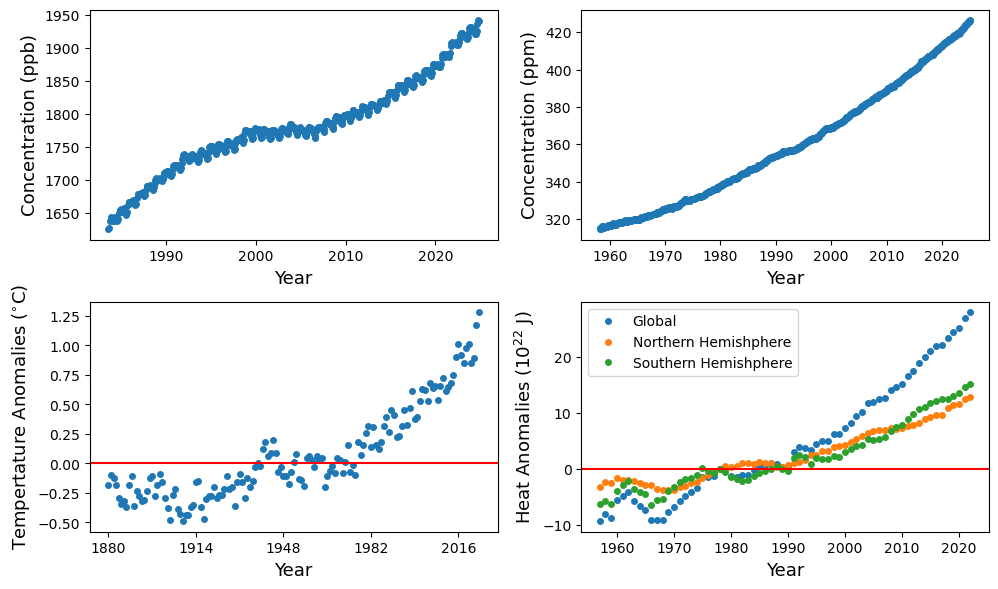

In [11]:
#name variables
y_ch4=df_ch4['Decimal Date']
df_ch4['Decimal Date'] = pd.to_numeric(df_ch4['Decimal Date'], errors='coerce')
ch4=df_ch4['Monthly Average CH₄ (ppb)']
u_ch4=df_ch4['Average Uncertainty (ppb)']

y_co2=df_co2['Decimal Date']
co2=df_co2['De-seasonalized CO₂ (ppm)']
u_co2=df_co2['Uncertainty of Monthly Mean']

y_T=df_T['Year']
T=df_T['Tempertature Anomalies (C)']

y_o=df_o['Year']
o=df_o['World Ocean Heat Content Anomaly (10$^{22}$ J)']
o_N=df_o['Northern Hemisphere Ocean Heat Content Anomaly (10$^{22}$ J)']
o_S=df_o['Southern Hemisphere Ocean Heat Content Anomaly (10$^{22}$ J)']

#create subplot

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,6))

ax1.plot(y_ch4, ch4, 'o', markersize=4, label=r'Concentration of $CH_4$')
ax1.set_xlabel('Year', fontsize=13)
ax1.set_ylabel('Concentration (ppb)', fontsize=13)

ax2.plot(y_co2, co2, 'o', markersize=4, label=r'Concentration of $CO_2$')
ax2.set_xlabel('Year', fontsize=13)
ax2.set_ylabel('Concentration (ppm)', fontsize=13)

T_ticks=np.arange(start=1880, stop= 2024, step=34)
ax3.plot(y_T, T, 'o', markersize=4, label=r'Data')
ax3.set_xlabel('Year', fontsize=13)
ax3.set_ylabel(r'Tempertature Anomalies ($^{\circ}$C)', fontsize=13)
ax3.axhline(y=0, color='red')
ax3.set_xticks(ticks=T_ticks)

ax4.plot(y_o, o, 'o', markersize=4, label=r'Global')
ax4.plot(y_o, o_N, 'o', markersize=4, label=r'Northern Hemishphere')
ax4.plot(y_o, o_S, 'o', markersize=4, label=r'Southern Hemishphere')
ax4.set_xlabel('Year', fontsize=13)
ax4.set_ylabel(r'Heat Anomalies (10$^{22}$ J)', fontsize=13)
ax4.axhline(y=0, color='red')

plt.legend()
fig.tight_layout()

## Curve Fitting Analysis

On a first approach, we will implement  polynomial curve fitting function, from scipy, to predict the next 25 years trend for each of one of those variables. Then, we will compare to the results predicted by using an LSTM neural network.

## Analysing the polynomial trend on the CH4 concentration

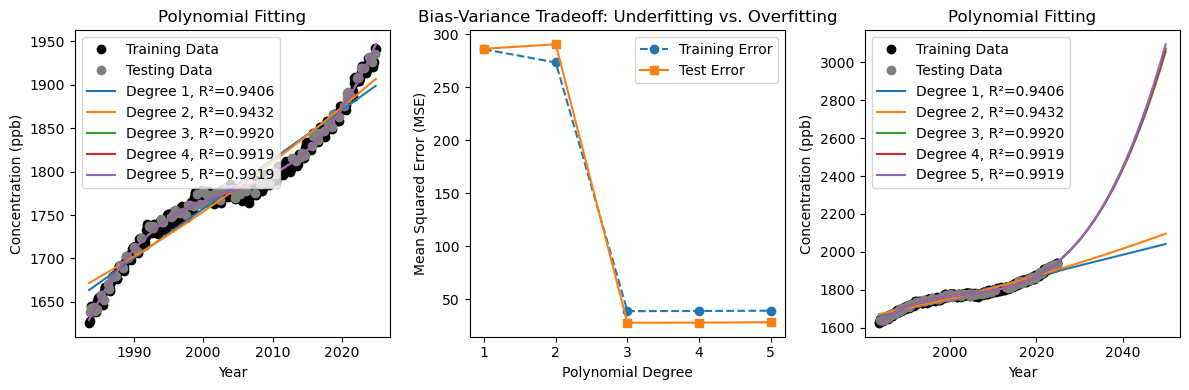

In [13]:
# Define a general polynomial function
def poly_func(x, *coeffs):
    return sum(c * x**i for i, c in enumerate(coeffs))

# Split data into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(y_ch4, ch4, test_size=0.2, random_state=15)

# Initialize lists to store errors
degrees = np.arange(1, 6, 1)
train_errors = []
test_errors = []

fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3, figsize=(12,4))

ax1.plot(X_train, y_train, 'o', label="Training Data", color="black")
ax1.plot(X_test, y_test, 'o', label="Testing Data", color="gray")

ax3.plot(X_train, y_train, 'o', label="Training Data", color="black")
ax3.plot(X_test, y_test, 'o', label="Testing Data", color="gray")

for d in degrees:
    p0 = np.ones(d + 1)  # Initial guess for coefficients
    
    # Fit curve with curve_fit on training data
    params, cov_matrix = curve_fit(lambda X_train, *p: poly_func(X_train, *p), X_train, y_train, p0=p0, maxfev=int(1e6))
    
    # Generate predictions for training and testing data
    y_train_pred = poly_func(X_train, *params)
    y_test_pred = poly_func(X_test, *params)
    
    # Compute errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    
    # Compute R^2
    r2 = 1 - (sum((y_train - y_train_pred) ** 2) / sum((y_train - np.mean(y_train)) ** 2))
    
    # Generate smooth curve for plotting
    x_smooth = np.linspace(min(y_ch4), max(y_ch4), len(y_ch4))
    y_smooth = poly_func(x_smooth, *params)
    ax1.plot(x_smooth, y_smooth, label=f"Degree {d}, R²={r2:.4f}")
    ax1.set_title('Polynomial Fitting')
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Concentration (ppb)")

    x_predict = np.linspace(min(y_ch4), 2050, int(2050 - min(y_ch4)))
    y_predict = poly_func(x_predict, *params)
    ax3.plot(x_predict, y_predict, label=f"Degree {d}, R²={r2:.4f}")
    ax3.set_title('Polynomial Fitting')
    ax3.set_xlabel("Year")
    ax3.set_ylabel("Concentration (ppb)")
    ax3.legend()

# Plot training vs test error

ax2.plot(degrees, train_errors, label='Training Error', marker='o', linestyle='--')
ax2.plot(degrees, test_errors, label='Test Error', marker='s', linestyle='-')
ax2.set_xlabel("Polynomial Degree")
ax2.set_ylabel("Mean Squared Error (MSE)")
ax2.set_title("Bias-Variance Tradeoff: Underfitting vs. Overfitting")
ax2.legend()

ax1.legend()
fig.tight_layout()
plt.show()


## Analysing the polynomial trend on the CO2 concentration

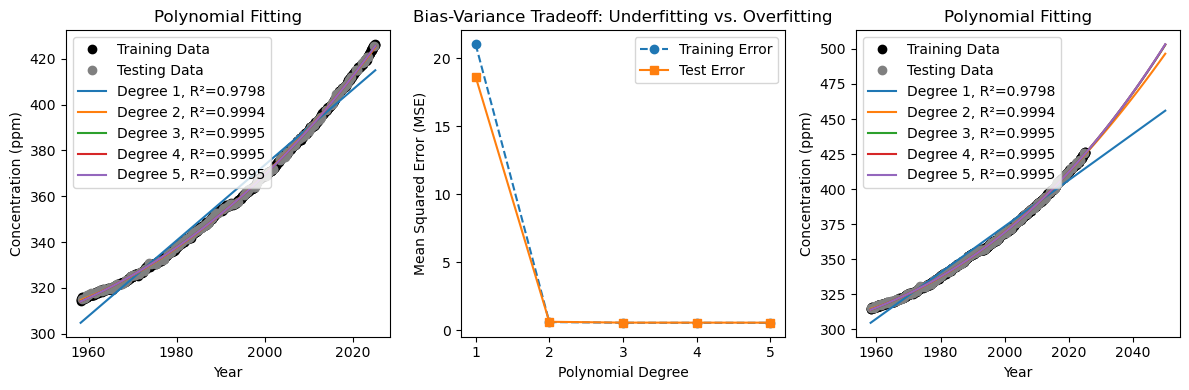

In [15]:
# Split data into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(y_co2, co2, test_size=0.2, random_state=15)

# Initialize lists to store errors
degrees = np.arange(1, 6, 1)
train_errors = []
test_errors = []

fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3, figsize=(12,4))

ax1.plot(X_train, y_train, 'o', label="Training Data", color="black")
ax1.plot(X_test, y_test, 'o', label="Testing Data", color="gray")

ax3.plot(X_train, y_train, 'o', label="Training Data", color="black")
ax3.plot(X_test, y_test, 'o', label="Testing Data", color="gray")

for d in degrees:
    p0 = np.ones(d + 1)  # Initial guess for coefficients
    
    # Fit curve with curve_fit on training data
    params, cov_matrix = curve_fit(lambda X_train, *p: poly_func(X_train, *p), X_train, y_train, p0=p0, maxfev=int(1e6))
    
    # Generate predictions for training and testing data
    y_train_pred = poly_func(X_train, *params)
    y_test_pred = poly_func(X_test, *params)
    
    # Compute errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    
    # Compute R^2
    r2 = 1 - (sum((y_train - y_train_pred) ** 2) / sum((y_train - np.mean(y_train)) ** 2))
    
    # Generate smooth curve for plotting
    x_smooth = np.linspace(min(y_co2), max(y_co2), len(y_co2))
    y_smooth = poly_func(x_smooth, *params)
    ax1.plot(x_smooth, y_smooth, label=f"Degree {d}, R²={r2:.4f}")
    ax1.set_title('Polynomial Fitting')
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Concentration (ppm)")

    x_predict = np.linspace(min(y_co2), 2050,  int(2050-min(y_co2)))
    y_predict = poly_func(x_predict, *params)
    ax3.plot(x_predict, y_predict, label=f"Degree {d}, R²={r2:.4f}")
    ax3.set_title('Polynomial Fitting')
    ax3.set_xlabel("Year")
    ax3.set_ylabel("Concentration (ppm)")
    ax3.legend()

# Plot training vs test error

ax2.plot(degrees, train_errors, label='Training Error', marker='o', linestyle='--')
ax2.plot(degrees, test_errors, label='Test Error', marker='s', linestyle='-')
ax2.set_xlabel("Polynomial Degree")
ax2.set_ylabel("Mean Squared Error (MSE)")
ax2.set_title("Bias-Variance Tradeoff: Underfitting vs. Overfitting")
ax2.legend()

ax1.legend()
fig.tight_layout()
plt.show()

## Analyzing the polynomial trend on the temperature anomalies data

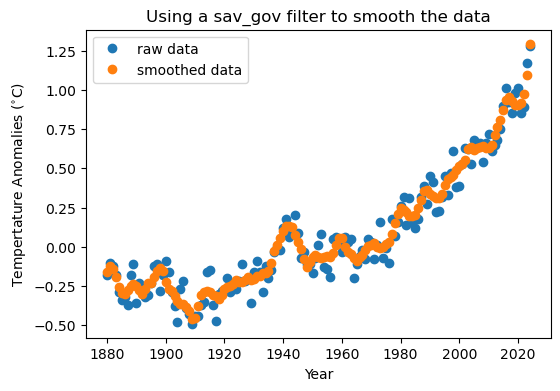

In [17]:
#as the data is noisy, let's apply a sav_gov filter

T_smoothed= savgol_filter(T, 10, 3)

fig, ax=plt.subplots(1,1, figsize=(6,4))

ax.plot(y_T,T,'o', label=r'raw data')
ax.plot(y_T,T_smoothed, 'o', label='smoothed data')
ax.set_xlabel('Year')
ax.set_ylabel(r'Tempertature Anomalies ($^{\circ}$C)')
plt.title('Using a sav_gov filter to smooth the data')
plt.legend()
plt.show()

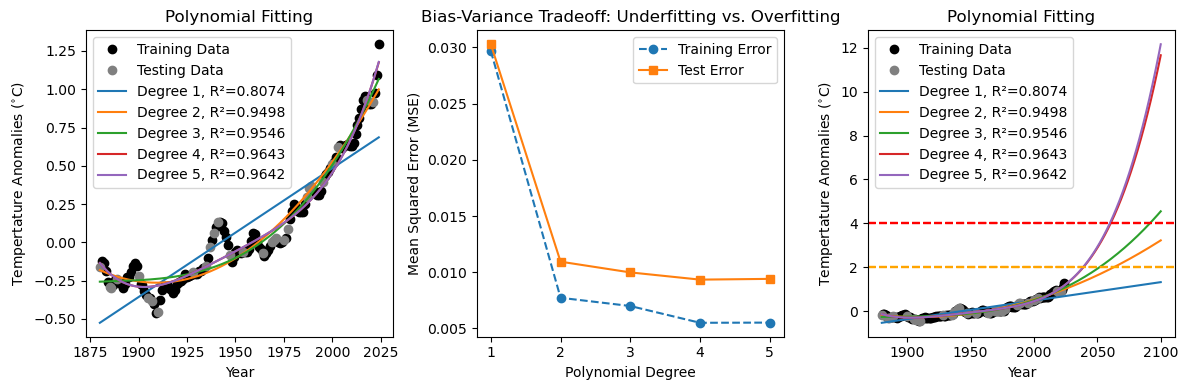

In [19]:

# Split data into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(y_T, T_smoothed, test_size=0.2, random_state=15)

# Initialize lists to store errors
degrees = np.arange(1, 6, 1)
train_errors = []
test_errors = []

fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3, figsize=(12,4))

ax1.plot(X_train, y_train, 'o', label="Training Data", color="black")
ax1.plot(X_test, y_test, 'o', label="Testing Data", color="gray")

ax3.plot(X_train, y_train, 'o', label="Training Data", color="black")
ax3.plot(X_test, y_test, 'o', label="Testing Data", color="gray")

for d in degrees:
    p0 = np.ones(d + 1)  # Initial guess for coefficients
    
    # Fit curve with curve_fit on training data
    params, cov_matrix = curve_fit(lambda X_train, *p: poly_func(X_train, *p), X_train, y_train, p0=p0, maxfev=int(1e6))
    
    # Generate predictions for training and testing data
    y_train_pred = poly_func(X_train, *params)
    y_test_pred = poly_func(X_test, *params)
    
    # Compute errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    
    # Compute R^2
    r2 = 1 - (sum((y_train - y_train_pred) ** 2) / sum((y_train - np.mean(y_train)) ** 2))
    
    # Generate smooth curve for plotting
    x_smooth = np.linspace(min(y_T), max(y_T), len(y_T))
    y_smooth = poly_func(x_smooth, *params)
    ax1.plot(x_smooth, y_smooth, label=f"Degree {d}, R²={r2:.4f}")
    ax1.set_title('Polynomial Fitting')
    ax1.set_xlabel("Year")
    ax1.set_ylabel(r"Tempertature Anomalies ($^{\circ}$C)")

    x_predict = np.linspace(min(y_T), 2100,  2050-min(y_T))
    y_predict = poly_func(x_predict, *params)
    ax3.plot(x_predict, y_predict, label=f"Degree {d}, R²={r2:.4f}")
    ax3.axhline(y=4,color='red',  linestyle='--')
    ax3.axhline(y=2,color='orange',  linestyle='--')
    ax3.set_title('Polynomial Fitting')
    ax3.set_xlabel("Year")
    ax3.set_ylabel(r"Tempertature Anomalies ($^{\circ}$C)")
    ax3.legend()

# Plot training vs test error

ax2.plot(degrees, train_errors, label='Training Error', marker='o', linestyle='--')
ax2.plot(degrees, test_errors, label='Test Error', marker='s', linestyle='-')
ax2.set_xlabel("Polynomial Degree")
ax2.set_ylabel("Mean Squared Error (MSE)")
ax2.set_title("Bias-Variance Tradeoff: Underfitting vs. Overfitting")
ax2.legend()

ax1.legend()
fig.tight_layout()
plt.show()

## Analyzing the Ocean's Heat Anomaly

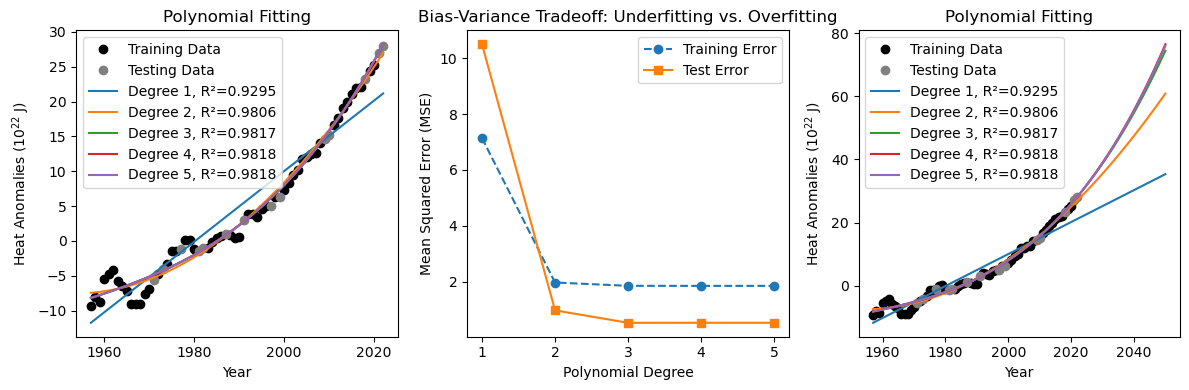

In [16]:

# Split data into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(y_o, o, test_size=0.2, random_state=15)

# Initialize lists to store errors
degrees = np.arange(1, 6, 1)
train_errors = []
test_errors = []

fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3, figsize=(12,4))

ax1.plot(X_train, y_train, 'o', label="Training Data", color="black")
ax1.plot(X_test, y_test, 'o', label="Testing Data", color="gray")

ax3.plot(X_train, y_train, 'o', label="Training Data", color="black")
ax3.plot(X_test, y_test, 'o', label="Testing Data", color="gray")

for d in degrees:
    p0 = np.ones(d + 1)  # Initial guess for coefficients
    
    # Fit curve with curve_fit on training data
    params, cov_matrix = curve_fit(lambda X_train, *p: poly_func(X_train, *p), X_train, y_train, p0=p0, maxfev=int(1e6))
    
    # Generate predictions for training and testing data
    y_train_pred = poly_func(X_train, *params)
    y_test_pred = poly_func(X_test, *params)
    
    # Compute errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    
    # Compute R^2
    r2 = 1 - (sum((y_train - y_train_pred) ** 2) / sum((y_train - np.mean(y_train)) ** 2))
    
    # Generate smooth curve for plotting
    x_smooth = np.linspace(min(y_o), max(y_o), len(y_o))
    y_smooth = poly_func(x_smooth, *params)
    ax1.plot(x_smooth, y_smooth, label=f"Degree {d}, R²={r2:.4f}")
    ax1.set_title('Polynomial Fitting')
    ax1.set_xlabel("Year")
    ax1.set_ylabel(r'Heat Anomalies (10$^{22}$ J)')

    x_predict = np.linspace(int(min(y_o)), 2050,  2050-int(min(y_o)))
    y_predict = poly_func(x_predict, *params)
    ax3.plot(x_predict, y_predict, label=f"Degree {d}, R²={r2:.4f}")
    ax3.set_title('Polynomial Fitting')
    ax3.set_xlabel("Year")
    ax3.set_ylabel(r'Heat Anomalies (10$^{22}$ J)')
    ax3.legend()

# Plot training vs test error

ax2.plot(degrees, train_errors, label='Training Error', marker='o', linestyle='--')
ax2.plot(degrees, test_errors, label='Test Error', marker='s', linestyle='-')
ax2.set_xlabel("Polynomial Degree")
ax2.set_ylabel("Mean Squared Error (MSE)")
ax2.set_title("Bias-Variance Tradeoff: Underfitting vs. Overfitting")
ax2.legend()

ax1.legend()
fig.tight_layout()
plt.show()

By analyzing the behavior of the Mean Squared Error (MSE) as the polynomial degree increases, we can identify the optimal polynomial degree that best fits the data while minimizing the risk of overfitting.

# Time-Series Forecasting with LSTM (Neural Network)

In this next section, we use the same dataset to train a Long Short-Term Memory (LSTM) neural network, aiming to forecast the behavior of the variables up to the year 2050. Following the prediction, we will comment on the model's performance and compare the quality of its forecasts against those generated through curve fitting.

## Methan (CH4) concentrations

In [49]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(ch4.values.reshape(-1, 1))


look_back = 50 
n_future = 300  

# Create sequences (multi-step target)
X, y = [], []
for i in range(len(data_scaled) - look_back - n_future):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back:i + look_back + n_future])

X = np.array(X)
y = np.array(y)
#we implement data augmentation by adding small level gaussian noise, to better train our model
def augment_with_gaussian_noise(data, num_augmentations=5, noise_levels=[0.001, 0.002, 0.005]):

    X_aug, y_aug = [], []
    data_len = len(data)

    for noise_std in noise_levels:
        for _ in range(num_augmentations):
            # Add small Gaussian noise
            noisy_data = data + np.random.normal(loc=0.0, scale=noise_std, size=data.shape)

            # Slide windows over the noisy data
            for i in range(data_len - look_back - n_future + 1):
                X_aug.append(noisy_data[i:i + look_back])
                y_aug.append(noisy_data[i + look_back:i + look_back + n_future])

    return np.array(X_aug), np.array(y_aug)

X_aug, y_aug = augment_with_gaussian_noise(data_scaled, num_augmentations=3)
print(X_aug.shape, y_aug.shape)

# Combine original and augmented data
X_combined = np.concatenate([X, X_aug])
y_combined = np.concatenate([y, y_aug])

# Split into train/val/test with random_state
train_size = 0.7  # 70% for training
val_size = 0.15   # 15% for validation
test_size = 0.15  # 15% for test

# First split to get the train and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=(val_size + test_size), random_state=42)

# Then split the temporary data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=42)

(1332, 50, 1) (1332, 300, 1)


(1332, 50, 1) (1332, 300, 1)


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


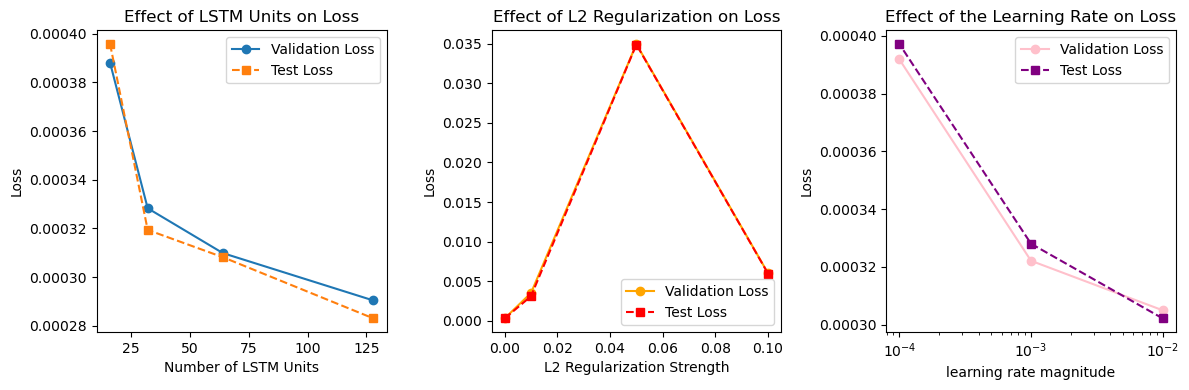

In [41]:

# Hyperparameter ranges
units_list = [16, 32, 64, 128]
reg_list = [0.0, 0.01, 0.05, 0.1]
alpha_list = [1e-2, 1e-3, 1e-4]


units_losses = []
units_test_losses = []
reg_losses = []
reg_test_losses = []
alpha_losses = []
alpha_test_losses = []

# Sweep LSTM units
for units in units_list:
    model = Sequential([
        LSTM(units, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(units, activation="relu"),
        Dense(n_future)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    units_losses.append(val_loss)
    units_test_losses.append(test_loss)

# Sweep regularization strengths
for reg in reg_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(reg)),
        LSTM(64, activation="relu", kernel_regularizer=regularizers.l2(reg)),
        Dense(n_future, kernel_regularizer=regularizers.l2(reg))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    reg_losses.append(val_loss)
    reg_test_losses.append(test_loss)

# Sweep learning rate
for alpha in alpha_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(64, activation="relu"),
        Dense(n_future)
        ])
    model.compile(optimizer=Adam(learning_rate=alpha), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    alpha_losses.append(val_loss)
    alpha_test_losses.append(test_loss)
                   
# Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Neurons
ax1.plot(units_list, units_losses, marker='o', label='Validation Loss')
ax1.plot(units_list, units_test_losses, marker='s', linestyle='--', label='Test Loss')
ax1.set_title("Effect of LSTM Units on Loss")
ax1.set_xlabel("Number of LSTM Units")
ax1.set_ylabel("Loss")
ax1.legend()

# Regularization
ax2.plot(reg_list, reg_losses, marker='o', color='orange', label='Validation Loss')
ax2.plot(reg_list, reg_test_losses, marker='s', linestyle='--', color='red', label='Test Loss')
ax2.set_title("Effect of L2 Regularization on Loss")
ax2.set_xlabel("L2 Regularization Strength")
ax2.set_ylabel("Loss")
ax2.legend()

#Learning Rate
ax3.plot(alpha_list, alpha_losses, marker='o', color='pink', label='Validation Loss')
ax3.plot(alpha_list, alpha_test_losses, marker='s', linestyle='--', color='purple', label='Test Loss')
ax3.set_title("Effect of the Learning Rate on Loss")
ax3.set_xlabel("learning rate magnitude")
ax3.set_ylabel("Loss")
ax3.set_xscale('log')
ax3.legend()

plt.tight_layout()
plt.show()





D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


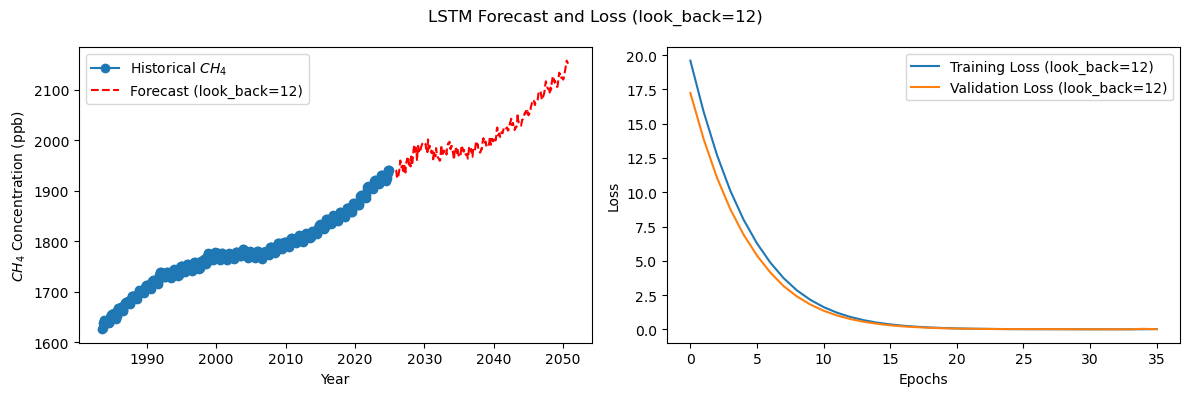

[look_back=12] Final Validation Loss: 0.0082, Test Loss: 0.0065


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


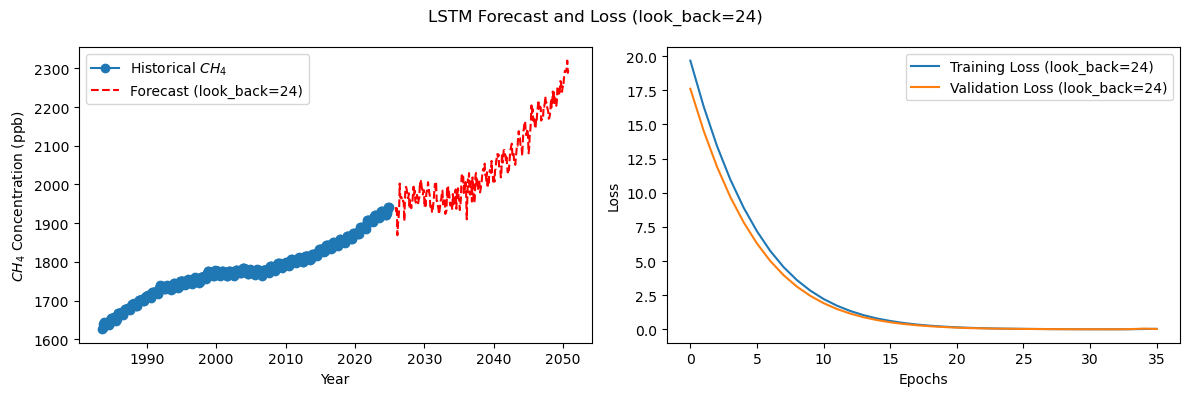

[look_back=24] Final Validation Loss: 0.0323, Test Loss: 0.0065


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


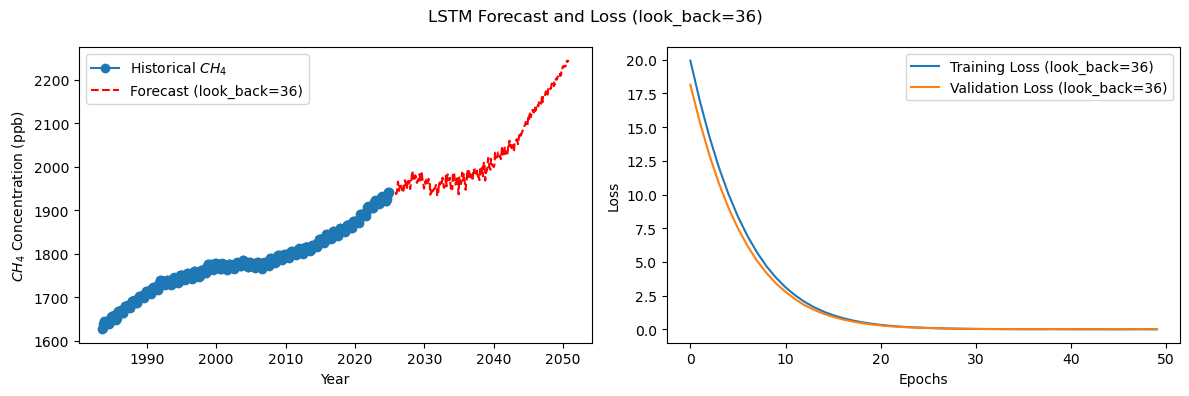

[look_back=36] Final Validation Loss: 0.0068, Test Loss: 0.0061


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


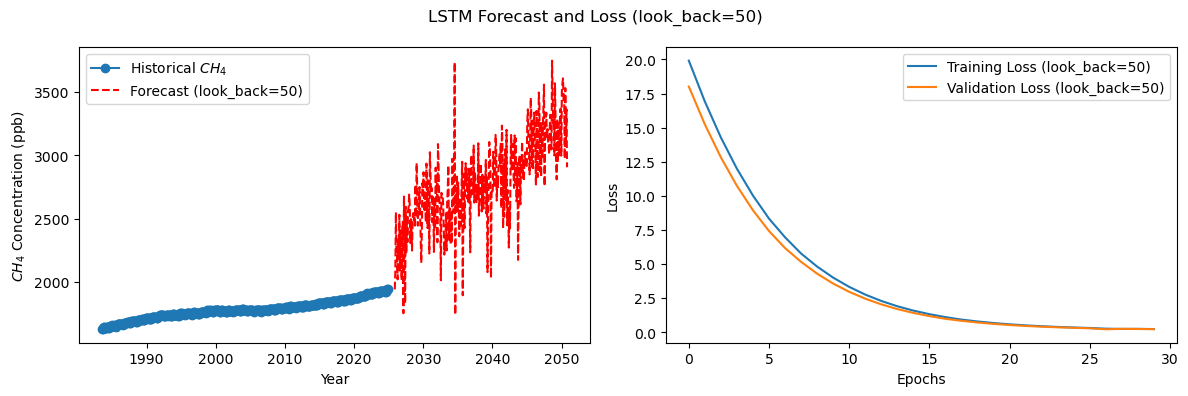

[look_back=50] Final Validation Loss: 0.2101, Test Loss: 0.2061


In [55]:
look_back_list = [12, 24, 36, 50]  
n_future = 300  

for look_back in look_back_list:
    # Recreate sequences for current look_back
    X, y = [], []
    for i in range(len(data_scaled) - look_back - n_future):
        X.append(data_scaled[i:i + look_back])
        y.append(data_scaled[i + look_back:i + look_back + n_future])
    X = np.array(X)
    y = np.array(y)

    # Train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Model definition
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(0.1)),
        LSTM(64, activation="relu", kernel_regularizer=regularizers.l2(0.1)),
        Dense(n_future, kernel_regularizer=regularizers.l2(0.1))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Forecast using the last sequence
    last_sequence = data_scaled[-look_back:]
    last_sequence = last_sequence.reshape(1, look_back, 1)
    future_preds = model.predict(last_sequence)[0]
    future_preds = scaler.inverse_transform(future_preds.reshape(-1, 1))

    # Generate future timeline
    years_future = np.arange(max(y_ch4) + 1, max(y_ch4) + 1 + n_future / 12, step=1 / 12)

    # Plot forecast and losses
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'LSTM Forecast and Loss (look_back={look_back})')

    # Forecast plot with dynamic label
    ax1.plot(y_ch4, ch4, label="Historical $CH_4$", marker="o")
    ax1.plot(
        years_future,
        future_preds.flatten() + (ch4.iloc[-1] - future_preds[0]),
        label=f"Forecast (look_back={look_back})",
        linestyle="dashed",
        color="red"
    )
    ax1.set_xlabel("Year")
    ax1.set_ylabel("$CH_4$ Concentration (ppb)")
    ax1.legend()
    
    # Loss plot 
    ax2.plot(history.history['loss'], label=f'Training Loss (look_back={look_back})')
    ax2.plot(history.history['val_loss'], label=f'Validation Loss (look_back={look_back})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    #Final validation loss
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"[look_back={look_back}] Final Validation Loss: {history.history['val_loss'][-1]:.4f}, Test Loss: {test_loss:.4f}")


Based on the predictions generated, we can infer which models are less likely to accurately represent the underlying reality. For instance, the model corresponding to the largest look-back value (50) appears to fail in capturing the trends present in the data, suggesting that it does not effectively reflect the temporal dependencies.

## Carbon Dioxide (CO2) Concentrations

In [57]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(co2.values.reshape(-1, 1))

look_back = 50 
n_future = 300  

# Create sequences (multi-step target)
X, y = [], []
for i in range(len(data_scaled) - look_back - n_future):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back:i + look_back + n_future])

X = np.array(X)
y = np.array(y)

X_aug, y_aug = augment_with_gaussian_noise(data_scaled, num_augmentations=3)
print(X_aug.shape, y_aug.shape)

# Combine original and augmented data
X_combined = np.concatenate([X, X_aug])
y_combined = np.concatenate([y, y_aug])

# Split into train/val/test with random_state
train_size = 0.7  # 70% for training
val_size = 0.15   # 15% for validation
test_size = 0.15  # 15% for test

# First split to get the train and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=(val_size + test_size), random_state=42)

# Then split the temporary data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=42)


(4095, 50, 1) (4095, 300, 1)


(4095, 50, 1) (4095, 300, 1)


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


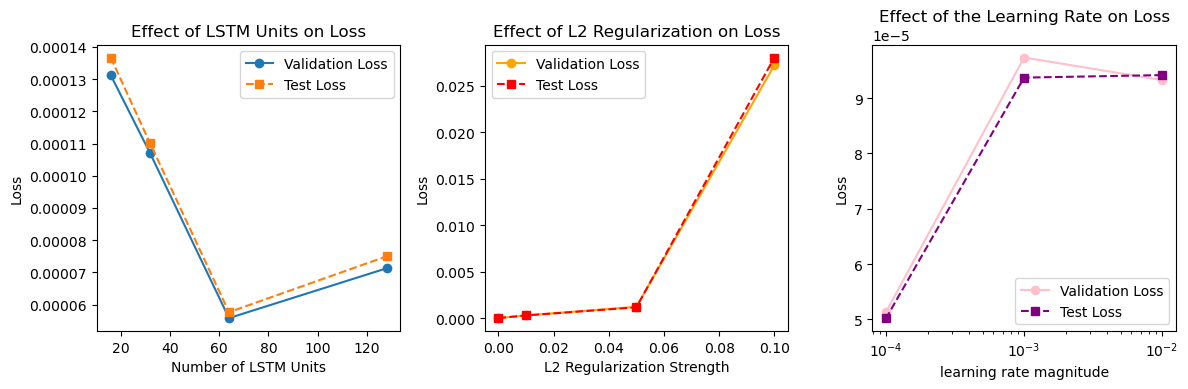

In [80]:

# Hyperparameter ranges
units_list = [16, 32, 64, 128]
reg_list = [0.0, 0.01, 0.05, 0.1]
alpha_list = [1e-2, 1e-3, 1e-4]


units_losses = []
units_test_losses = []
reg_losses = []
reg_test_losses = []
alpha_losses = []
alpha_test_losses = []

# Sweep LSTM units
for units in units_list:
    model = Sequential([
        LSTM(units, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(units, activation="relu"),
        Dense(n_future)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    units_losses.append(val_loss)
    units_test_losses.append(test_loss)

# Sweep regularization strengths
for reg in reg_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(reg)),
        LSTM(64, activation="relu", kernel_regularizer=regularizers.l2(reg)),
        Dense(n_future, kernel_regularizer=regularizers.l2(reg))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    reg_losses.append(val_loss)
    reg_test_losses.append(test_loss)

# Sweep learning rate
for alpha in alpha_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(64, activation="relu"),
        Dense(n_future)
        ])
    model.compile(optimizer=Adam(learning_rate=alpha), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    alpha_losses.append(val_loss)
    alpha_test_losses.append(test_loss)
                   
# Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Neurons
ax1.plot(units_list, units_losses, marker='o', label='Validation Loss')
ax1.plot(units_list, units_test_losses, marker='s', linestyle='--', label='Test Loss')
ax1.set_title("Effect of LSTM Units on Loss")
ax1.set_xlabel("Number of LSTM Units")
ax1.set_ylabel("Loss")
ax1.legend()

# Regularization
ax2.plot(reg_list, reg_losses, marker='o', color='orange', label='Validation Loss')
ax2.plot(reg_list, reg_test_losses, marker='s', linestyle='--', color='red', label='Test Loss')
ax2.set_title("Effect of L2 Regularization on Loss")
ax2.set_xlabel("L2 Regularization Strength")
ax2.set_ylabel("Loss")
ax2.legend()

# learning rate
ax3.plot(alpha_list, alpha_losses, marker='o', color='pink', label='Validation Loss')
ax3.plot(alpha_list, alpha_test_losses, marker='s', linestyle='--', color='purple', label='Test Loss')
ax3.set_title("Effect of the Learning Rate on Loss")
ax3.set_xlabel("learning rate magnitude")
ax3.set_ylabel("Loss")
ax3.set_xscale('log')
ax3.legend()

plt.tight_layout()
plt.show()





D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


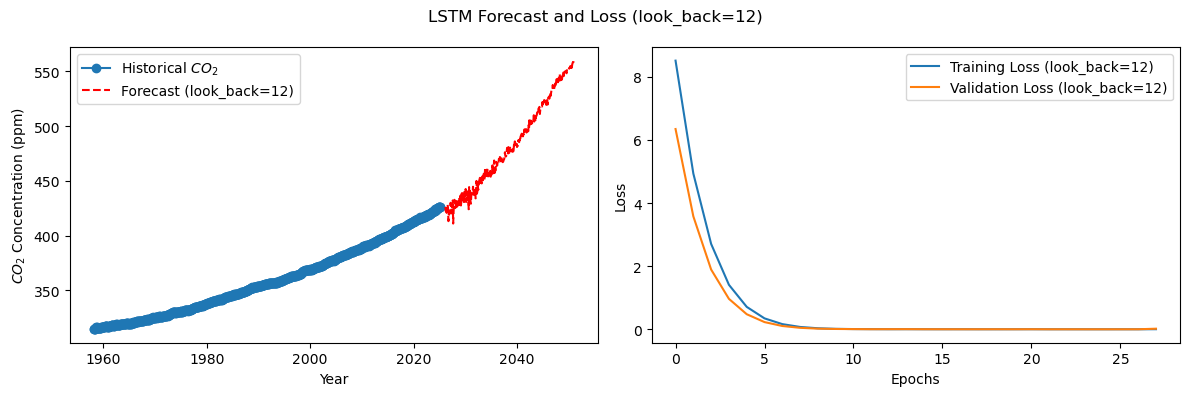

[look_back=12] Final Validation Loss: 0.0218, Test Loss: 0.0034


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


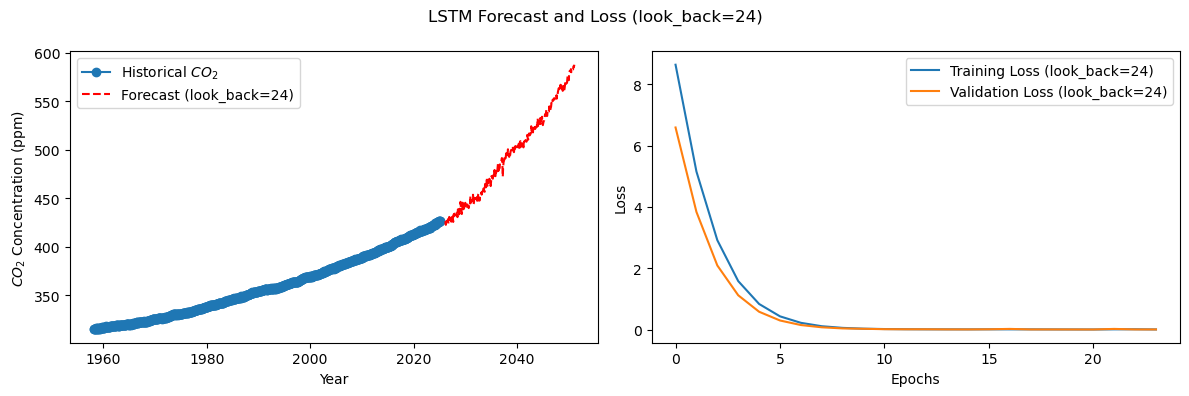

[look_back=24] Final Validation Loss: 0.0036, Test Loss: 0.0026


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


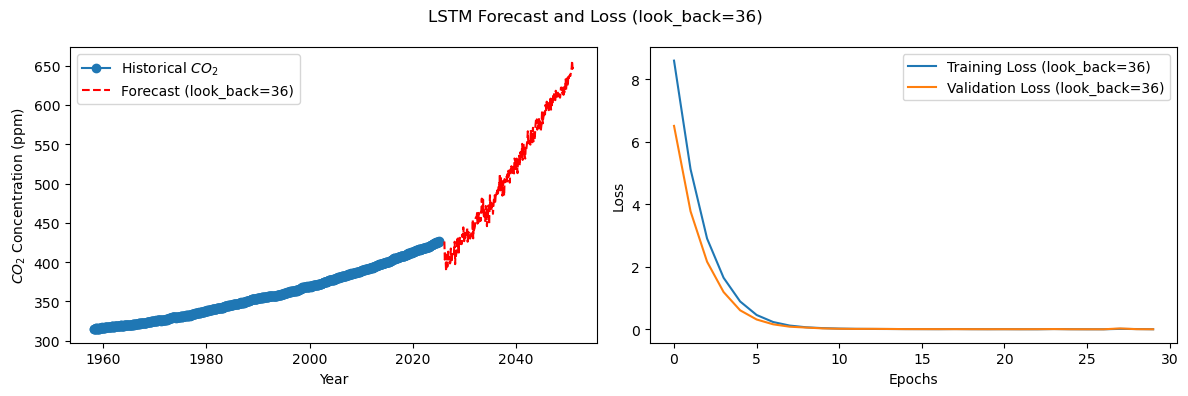

[look_back=36] Final Validation Loss: 0.0044, Test Loss: 0.0033


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


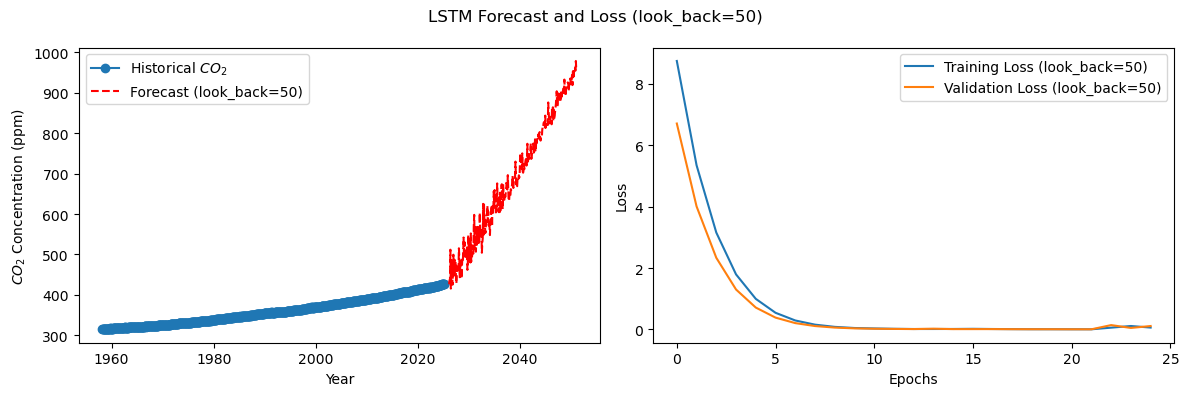

[look_back=50] Final Validation Loss: 0.1107, Test Loss: 0.0034


In [59]:
look_back_list = [12, 24, 36, 50]  
n_future = 300  

for look_back in look_back_list:
    # Recreate sequences for current look_back
    X, y = [], []
    for i in range(len(data_scaled) - look_back - n_future):
        X.append(data_scaled[i:i + look_back])
        y.append(data_scaled[i + look_back:i + look_back + n_future])
    X = np.array(X)
    y = np.array(y)

    # Train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Model definition
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(0.05)),
        LSTM(64, activation="relu", kernel_regularizer=regularizers.l2(0.05)),
        Dense(n_future, kernel_regularizer=regularizers.l2(0.05))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse") #no need to choose the smallest, longer computational time for an already small loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Forecast using the last sequence
    last_sequence = data_scaled[-look_back:]
    last_sequence = last_sequence.reshape(1, look_back, 1)
    future_preds = model.predict(last_sequence)[0]
    future_preds = scaler.inverse_transform(future_preds.reshape(-1, 1))

    # Generate future timeline
    years_future = np.arange(max(y_co2) + 1, max(y_co2) + 1 + n_future / 12, step=1 / 12)

    # Plot forecast and losses
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'LSTM Forecast and Loss (look_back={look_back})')

    # Forecast plot with dynamic label
    ax1.plot(y_co2, co2, label="Historical $CO_2$", marker="o")
    ax1.plot(
        years_future,
        future_preds.flatten() + (co2.iloc[-1] - future_preds[0]),
        label=f"Forecast (look_back={look_back})",
        linestyle="dashed",
        color="red"
    )
    ax1.set_xlabel("Year")
    ax1.set_ylabel("$CO_2$ Concentration (ppm)")
    ax1.legend()
    
    # Loss plot 
    ax2.plot(history.history['loss'], label=f'Training Loss (look_back={look_back})')
    ax2.plot(history.history['val_loss'], label=f'Validation Loss (look_back={look_back})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()


    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"[look_back={look_back}] Final Validation Loss: {history.history['val_loss'][-1]:.4f}, Test Loss: {test_loss:.4f}")

## Global Temperature Anomalies

In [206]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(T_smoothed.reshape(-1, 1))

look_back = 10 
n_future = 25  

# Create sequences (multi-step target)
X, y = [], []
for i in range(len(data_scaled) - look_back - n_future):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back:i + look_back + n_future])

X = np.array(X)
y = np.array(y)

X_aug, y_aug = augment_with_gaussian_noise(data_scaled, num_augmentations=3)
print(X_aug.shape, y_aug.shape)

# Combine original and augmented data
X_combined = np.concatenate([X, X_aug])
y_combined = np.concatenate([y, y_aug])

# Split into train/val/test with random_state
train_size = 0.7  # 70% for training
val_size = 0.15   # 15% for validation
test_size = 0.15  # 15% for test

# First split to get the train and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=(val_size + test_size), random_state=42)

# Then split the temporary data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=42)


(999, 10, 1) (999, 25, 1)


(999, 10, 1) (999, 25, 1)


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


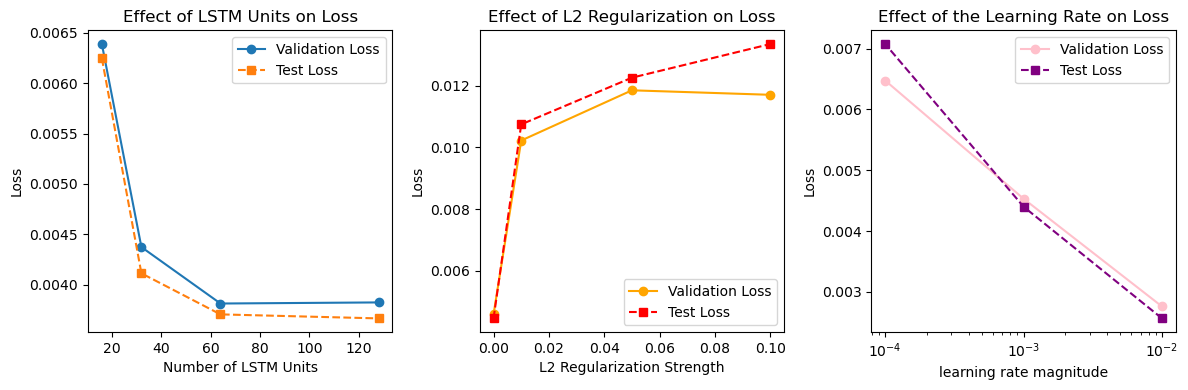

In [101]:
# Hyperparameter ranges
units_list = [16, 32, 64, 128]
reg_list = [0.0, 0.01, 0.05, 0.1]
alpha_list = [1e-2, 1e-3, 1e-4]


units_losses = []
units_test_losses = []
reg_losses = []
reg_test_losses = []
alpha_losses = []
alpha_test_losses = []

# Sweep LSTM units
for units in units_list:
    model = Sequential([
        LSTM(units, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(units, activation="relu"),
        Dense(n_future)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    units_losses.append(val_loss)
    units_test_losses.append(test_loss)

# Sweep regularization strengths
for reg in reg_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(reg)),
        LSTM(64, activation="relu", kernel_regularizer=regularizers.l2(reg)),
        Dense(n_future, kernel_regularizer=regularizers.l2(reg))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    reg_losses.append(val_loss)
    reg_test_losses.append(test_loss)

# Sweep learning rate
for alpha in alpha_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(64, activation="relu"),
        Dense(n_future)
        ])
    model.compile(optimizer=Adam(learning_rate=alpha), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    alpha_losses.append(val_loss)
    alpha_test_losses.append(test_loss)
                   
# Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Neurons
ax1.plot(units_list, units_losses, marker='o', label='Validation Loss')
ax1.plot(units_list, units_test_losses, marker='s', linestyle='--', label='Test Loss')
ax1.set_title("Effect of LSTM Units on Loss")
ax1.set_xlabel("Number of LSTM Units")
ax1.set_ylabel("Loss")
ax1.legend()

# Regularization
ax2.plot(reg_list, reg_losses, marker='o', color='orange', label='Validation Loss')
ax2.plot(reg_list, reg_test_losses, marker='s', linestyle='--', color='red', label='Test Loss')
ax2.set_title("Effect of L2 Regularization on Loss")
ax2.set_xlabel("L2 Regularization Strength")
ax2.set_ylabel("Loss")
ax2.legend()

# learning rate
ax3.plot(alpha_list, alpha_losses, marker='o', color='pink', label='Validation Loss')
ax3.plot(alpha_list, alpha_test_losses, marker='s', linestyle='--', color='purple', label='Test Loss')
ax3.set_title("Effect of the Learning Rate on Loss")
ax3.set_xlabel("learning rate magnitude")
ax3.set_ylabel("Loss")
ax3.set_xscale('log')
ax3.legend()

plt.tight_layout()
plt.show()





D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


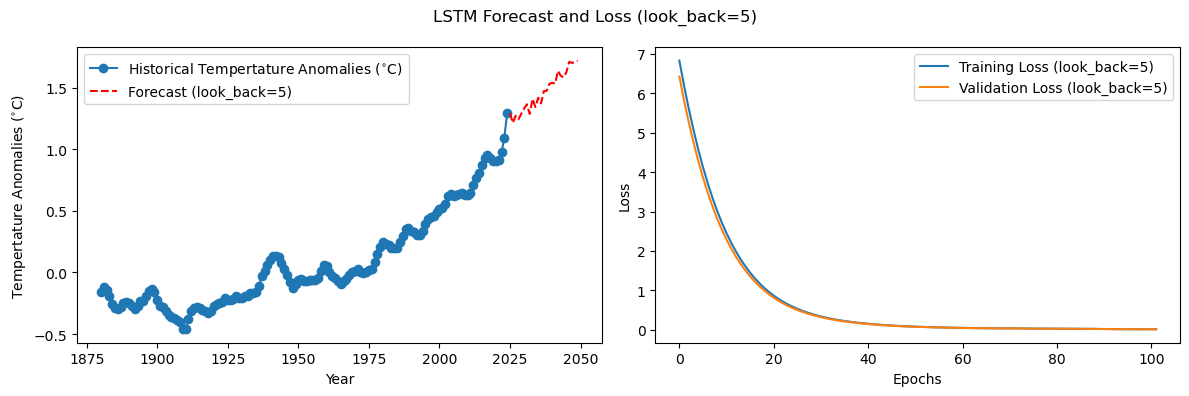

[look_back=5] Final Validation Loss: 0.0158, Test Loss: 0.0133


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


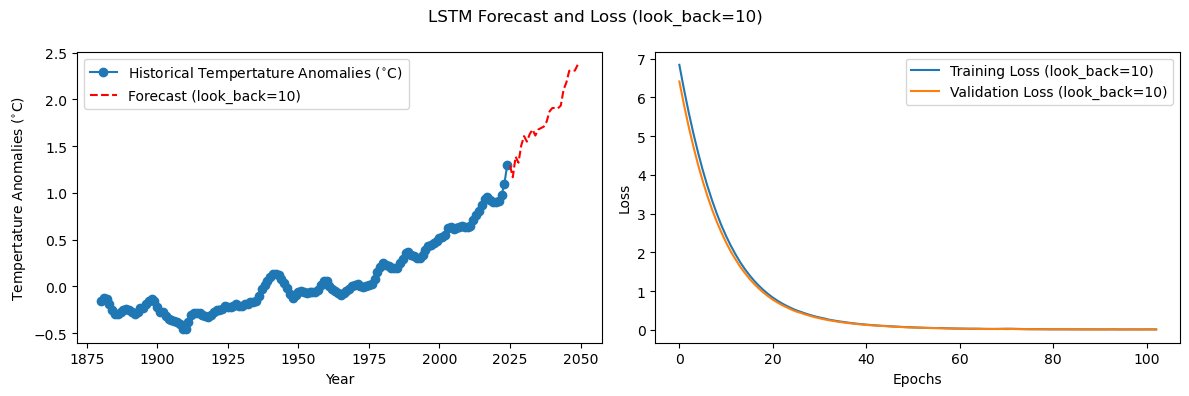

[look_back=10] Final Validation Loss: 0.0132, Test Loss: 0.0123


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


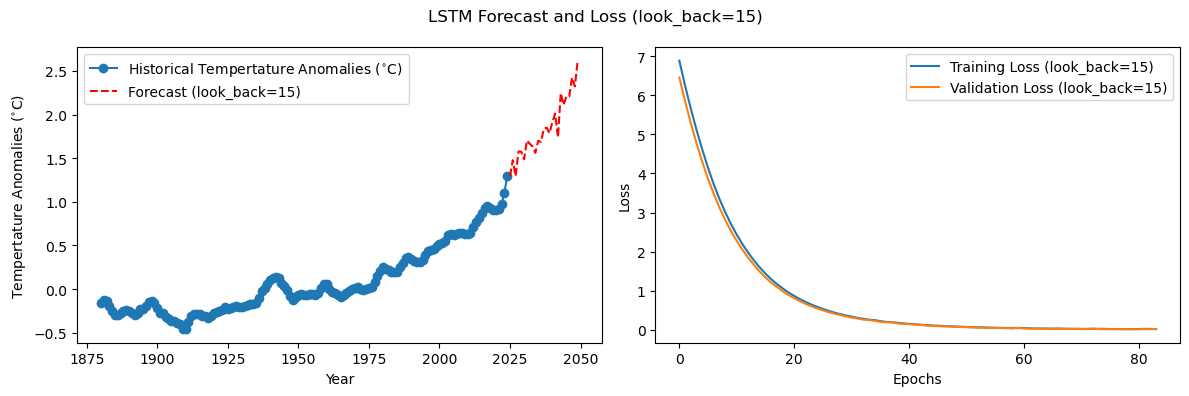

[look_back=15] Final Validation Loss: 0.0197, Test Loss: 0.0179


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


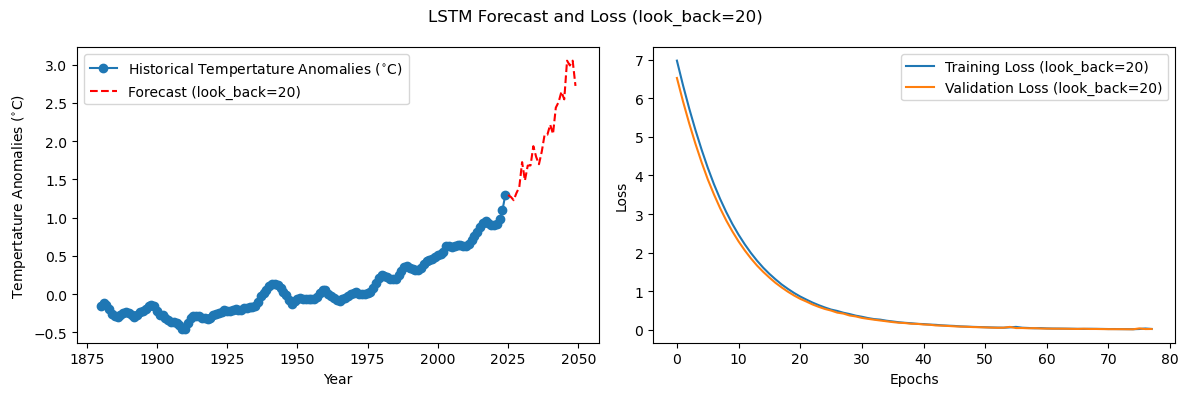

[look_back=20] Final Validation Loss: 0.0256, Test Loss: 0.0173


In [212]:
look_back_list = [5, 10, 15, 20]  
n_future = 25  

for look_back in look_back_list:
    # Recreate sequences for current look_back
    X, y = [], []
    for i in range(len(data_scaled) - look_back - n_future):
        X.append(data_scaled[i:i + look_back])
        y.append(data_scaled[i + look_back:i + look_back + n_future])
    X = np.array(X)
    y = np.array(y)

    # Train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Model definition
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(0.05)),
        LSTM(64, activation="relu", kernel_regularizer=regularizers.l2(0.05)),
        Dense(n_future, kernel_regularizer=regularizers.l2(0.05))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Forecast using the last sequence
    last_sequence = data_scaled[-look_back:]
    last_sequence = last_sequence.reshape(1, look_back, 1)
    future_preds = model.predict(last_sequence)[0]
    future_preds = scaler.inverse_transform(future_preds.reshape(-1, 1))

    # Generate future timeline
    years_future = np.arange(max(y_T) + 1, max(y_T) + 1 + n_future , step=1)

    # Plot forecast and losses
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'LSTM Forecast and Loss (look_back={look_back})')

    # Forecast plot with dynamic label
    ax1.plot(y_T, T_smoothed, label=r"Historical Tempertature Anomalies ($^{\circ}$C)", marker="o")
    ax1.plot(
        years_future,
        future_preds.flatten() + (T_smoothed[-1] - future_preds[0]),
        label=f"Forecast (look_back={look_back})",
        linestyle="dashed",
        color="red"
    )
    ax1.set_xlabel("Year")
    ax1.set_ylabel(r"Tempertature Anomalies ($^{\circ}$C)")
    ax1.legend()
    
    # Loss plot 
    ax2.plot(history.history['loss'], label=f'Training Loss (look_back={look_back})')
    ax2.plot(history.history['val_loss'], label=f'Validation Loss (look_back={look_back})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Optionally evaluate on test set
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"[look_back={look_back}] Final Validation Loss: {history.history['val_loss'][-1]:.4f}, Test Loss: {test_loss:.4f}")

## Ocean Heat Anomalies

In [119]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(o.values.reshape(-1, 1))

look_back = 10 
n_future = 25  # Predict 300 months (25 years) ahead

# Create sequences (multi-step target)
X, y = [], []
for i in range(len(data_scaled) - look_back - n_future):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back:i + look_back + n_future])

X = np.array(X)
y = np.array(y)

X_aug, y_aug = augment_with_gaussian_noise(data_scaled, num_augmentations=5)
print(X_aug.shape, y_aug.shape)

# Combine original and augmented data
X_combined = np.concatenate([X, X_aug])
y_combined = np.concatenate([y, y_aug])

# Split into train/val/test with random_state
train_size = 0.7  # 70% for training
val_size = 0.15   # 15% for validation
test_size = 0.15  # 15% for test

# First split to get the train and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=(val_size + test_size), random_state=42)

# Then split the temporary data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=42)

(800, 10, 1) (800, 25, 1)


(800, 10, 1) (800, 25, 1)


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


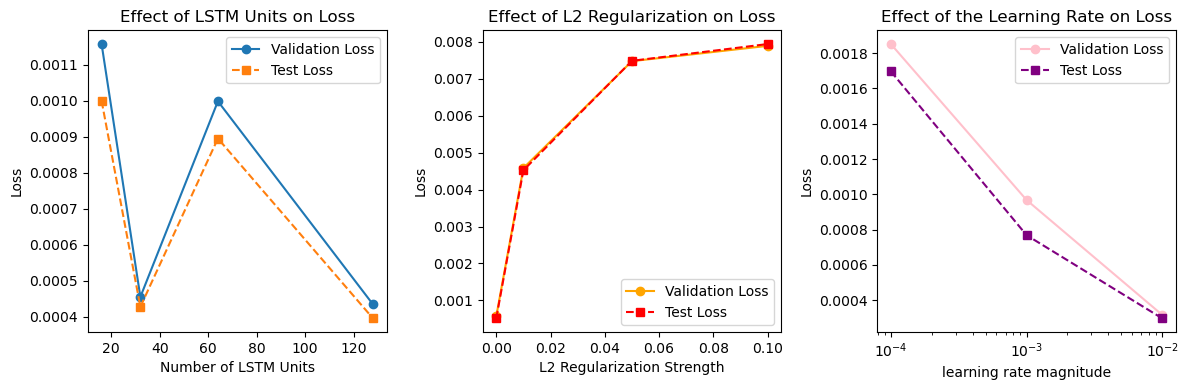

In [109]:
# Hyperparameter ranges
units_list = [16, 32, 64, 128]
reg_list = [0.0, 0.01, 0.05, 0.1]
alpha_list = [1e-2, 1e-3, 1e-4]


units_losses = []
units_test_losses = []
reg_losses = []
reg_test_losses = []
alpha_losses = []
alpha_test_losses = []

# Sweep LSTM units
for units in units_list:
    model = Sequential([
        LSTM(units, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(units, activation="relu"),
        Dense(n_future)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    units_losses.append(val_loss)
    units_test_losses.append(test_loss)

# Sweep regularization strengths
for reg in reg_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(reg)),
        LSTM(64, activation="relu", kernel_regularizer=regularizers.l2(reg)),
        Dense(n_future, kernel_regularizer=regularizers.l2(reg))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    reg_losses.append(val_loss)
    reg_test_losses.append(test_loss)

# Sweep learning rate
for alpha in alpha_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(64, activation="relu"),
        Dense(n_future)
        ])
    model.compile(optimizer=Adam(learning_rate=alpha), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    alpha_losses.append(val_loss)
    alpha_test_losses.append(test_loss)
                   
# Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Neurons
ax1.plot(units_list, units_losses, marker='o', label='Validation Loss')
ax1.plot(units_list, units_test_losses, marker='s', linestyle='--', label='Test Loss')
ax1.set_title("Effect of LSTM Units on Loss")
ax1.set_xlabel("Number of LSTM Units")
ax1.set_ylabel("Loss")
ax1.legend()

# Regularization
ax2.plot(reg_list, reg_losses, marker='o', color='orange', label='Validation Loss')
ax2.plot(reg_list, reg_test_losses, marker='s', linestyle='--', color='red', label='Test Loss')
ax2.set_title("Effect of L2 Regularization on Loss")
ax2.set_xlabel("L2 Regularization Strength")
ax2.set_ylabel("Loss")
ax2.legend()

# learning rate
ax3.plot(alpha_list, alpha_losses, marker='o', color='pink', label='Validation Loss')
ax3.plot(alpha_list, alpha_test_losses, marker='s', linestyle='--', color='purple', label='Test Loss')
ax3.set_title("Effect of the Learning Rate on Loss")
ax3.set_xlabel("learning rate magnitude")
ax3.set_ylabel("Loss")
ax3.set_xscale('log')
ax3.legend()

plt.tight_layout()
plt.show()




D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


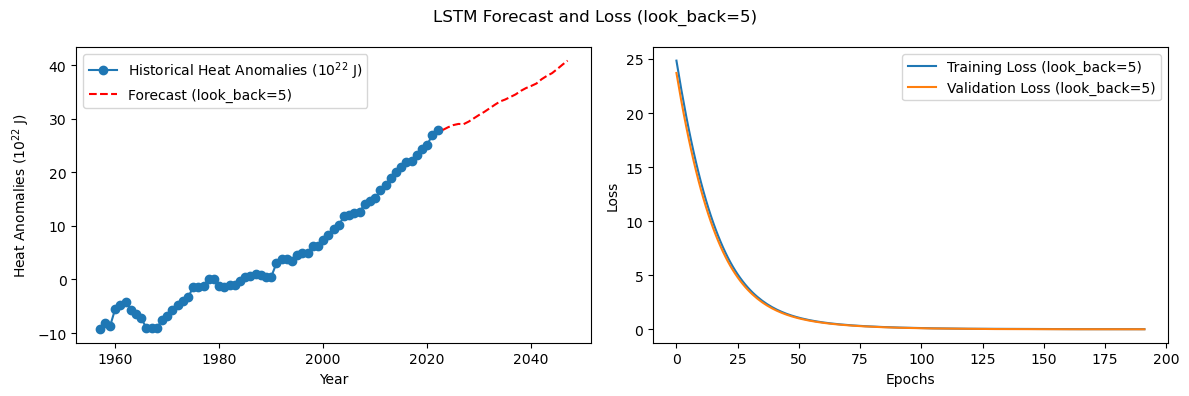

[look_back=5] Final Validation Loss: 0.0166, Test Loss: 0.0343


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


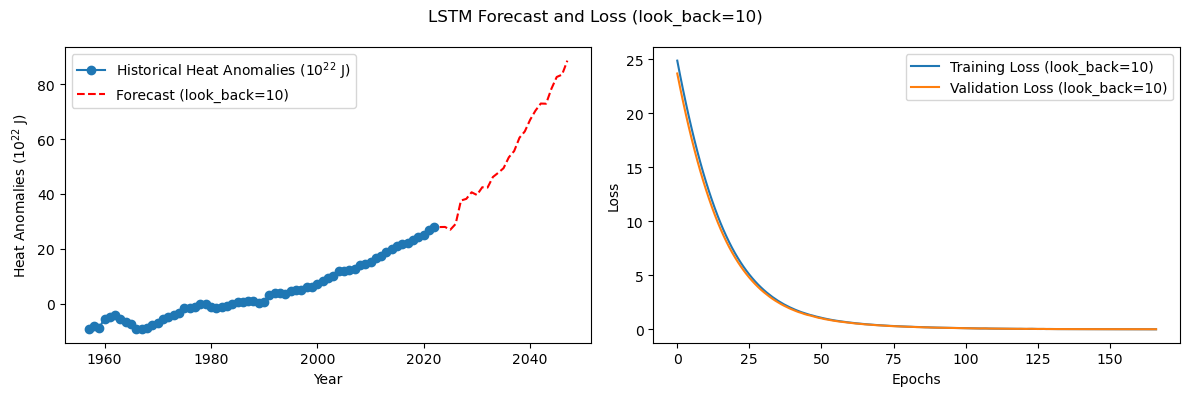

[look_back=10] Final Validation Loss: 0.0181, Test Loss: 0.0126


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


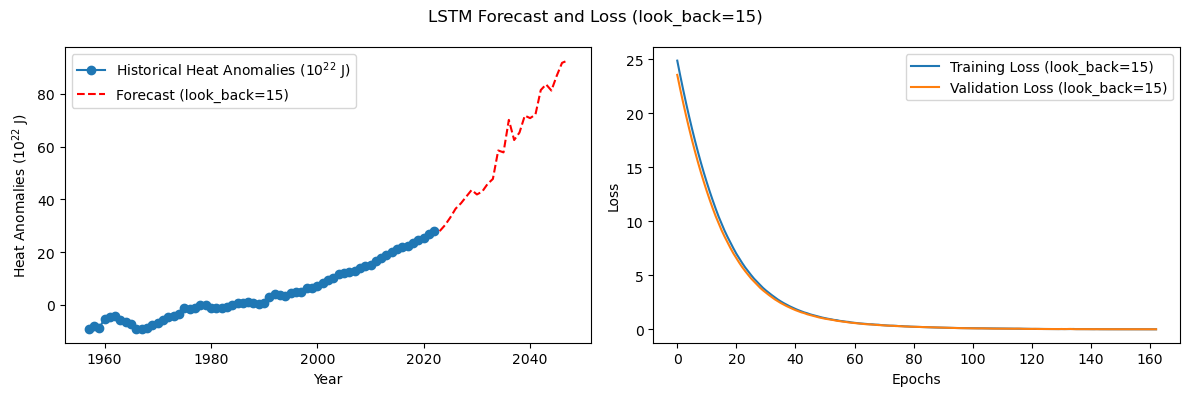

[look_back=15] Final Validation Loss: 0.0141, Test Loss: 0.0136


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


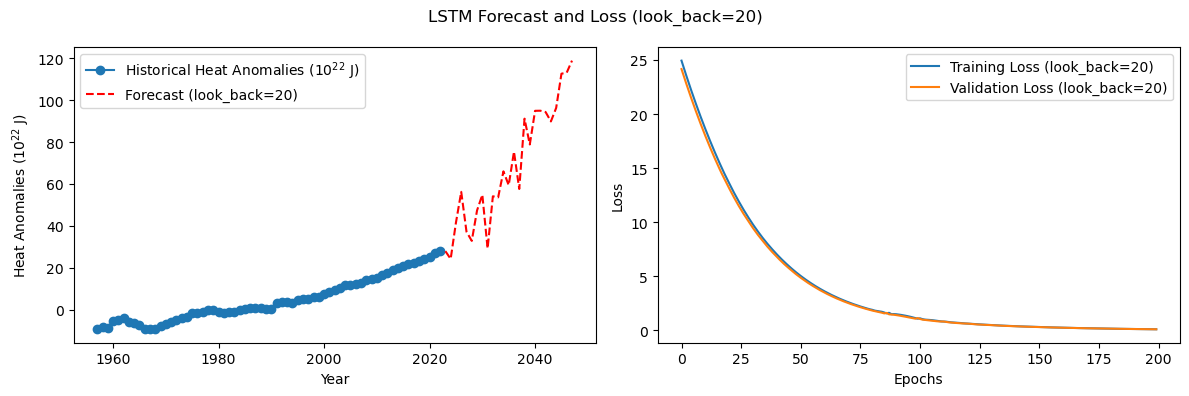

[look_back=20] Final Validation Loss: 0.1062, Test Loss: 0.1052


In [121]:
look_back_list = [5, 10, 15, 20]  
n_future = 25 

for look_back in look_back_list:
    # Recreate sequences for current look_back
    X, y = [], []
    for i in range(len(data_scaled) - look_back - n_future):
        X.append(data_scaled[i:i + look_back])
        y.append(data_scaled[i + look_back:i + look_back + n_future])
    X = np.array(X)
    y = np.array(y)

    # Train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Model definition
    model = Sequential([
        LSTM(128, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(0.1)),
        LSTM(128, activation="relu", kernel_regularizer=regularizers.l2(0.1)),
        Dense(n_future, kernel_regularizer=regularizers.l2(0.1))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Forecast using the last sequence
    last_sequence = data_scaled[-look_back:]
    last_sequence = last_sequence.reshape(1, look_back, 1)
    future_preds = model.predict(last_sequence)[0]
    future_preds = scaler.inverse_transform(future_preds.reshape(-1, 1))

    # Generate future timeline
    years_future = np.arange(max(y_o) + 1, max(y_o) + 1 + n_future , step=1)

    # Plot forecast and losses
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'LSTM Forecast and Loss (look_back={look_back})')

    # Forecast plot with dynamic label
    ax1.plot(y_o, o, label=r"Historical Heat Anomalies (10$^{22}$ J)", marker="o")
    ax1.plot(
        years_future,
        future_preds.flatten() + (o.iloc[-1] - future_preds[0]),
        label=f"Forecast (look_back={look_back})",
        linestyle="dashed",
        color="red"
    )
    ax1.set_xlabel("Year")
    ax1.set_ylabel(r'Heat Anomalies (10$^{22}$ J)')
    ax1.legend()
    
    # Loss plot 
    ax2.plot(history.history['loss'], label=f'Training Loss (look_back={look_back})')
    ax2.plot(history.history['val_loss'], label=f'Validation Loss (look_back={look_back})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()


    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"[look_back={look_back}] Final Validation Loss: {history.history['val_loss'][-1]:.4f}, Test Loss: {test_loss:.4f}")

## Curve Fitting VS LSTM Neural Network Model
While curve fitting offers a straightforward method for identifying general trends within data, it falls short as a predictive tool—particularly in dynamic contexts where underlying patterns and temporal dependencies are critical. In contrast, Long Short-Term Memory (LSTM) models excel in capturing complex, time-dependent behaviors. By learning from historical variations, LSTMs provide more robust and realistic forecasts, making them a powerful choice for time series prediction tasks.

## Food Price Index Analysis

In [192]:
df_food= pd.read_csv(r'Assets\food_price_indices_data.csv', skiprows=1, sep=',')
df_food.columns= df_food.loc[0]
df_food = df_food.drop(index=[0,1])
df_food = df_food.drop(columns=df_food.columns[7:])
df_food.head()

0     Date Food Price Index  Meat Dairy Cereals   Oils Sugar
2  1990-01             64.4  74.3  53.5    64.1  44.59  87.9
3  1990-02             64.7  76.8  52.2    62.2  44.50  90.7
4  1990-03             64.0  78.5  41.4    61.3  45.75  95.1
5  1990-04             66.0  81.2  48.4    62.8  44.02  94.3
6  1990-05             64.6  81.8  39.2    62.0  45.50  90.4

In [194]:
# Checking if there are any NaN values
has_nan = df_food.isna().any().any()
print(f"DataFrame contains NaN values: {has_nan}")

DataFrame contains NaN values: False


In [196]:
df_food['Date'] = pd.to_datetime(df_food['Date'])
df_food.head()
df_food['Year'] = df_food['Date'].dt.year
df_food['Month'] = df_food['Date'].dt.month
df_food['Decimal Date'] = df_food['Year'] + (df_food['Month']/12)
df_food.head()

0       Date Food Price Index  Meat Dairy Cereals   Oils Sugar  Year  Month  \
2 1990-01-01             64.4  74.3  53.5    64.1  44.59  87.9  1990      1   
3 1990-02-01             64.7  76.8  52.2    62.2  44.50  90.7  1990      2   
4 1990-03-01             64.0  78.5  41.4    61.3  45.75  95.1  1990      3   
5 1990-04-01             66.0  81.2  48.4    62.8  44.02  94.3  1990      4   
6 1990-05-01             64.6  81.8  39.2    62.0  45.50  90.4  1990      5   

0  Decimal Date  
2   1990.083333  
3   1990.166667  
4   1990.250000  
5   1990.333333  
6   1990.416667

In [198]:
df_food = df_food.apply(pd.to_numeric, errors='coerce')

# naame the variables
date = df_food['Decimal Date']
f_i = df_food['Food Price Index']   

#The FAO Food Price Index (f_i) is a composite measure that tracks the monthly change
# in international prices of a basket of food commodities.

meat = df_food['Meat']  
# Meat Price Index (meat) monitors the average international prices of 
# meat products, encompassing bovine, pig, poultry, and ovine meats.

dairy = df_food['Dairy']
#Dairy Price Index (dairy) captures the average international prices of 
#dairy products, including butter, skim milk powder, whole milk powder, and cheese.

cereals = df_food['Cereals']

#The Cereal Price Index (cereals) reflects the average international prices of cereals
#such as wheat, maize, and rice.

oils = df_food['Oils']

#Oil Price Index (oils) tracks the average international prices of vegetable oils,
#including palm, soy, rapeseed, and sunflower oils.

sugar = df_food['Sugar']

#Sugar Price Index (sugar) measures the average international prices of sugar, 
# based on the International Sugar Agreement price.


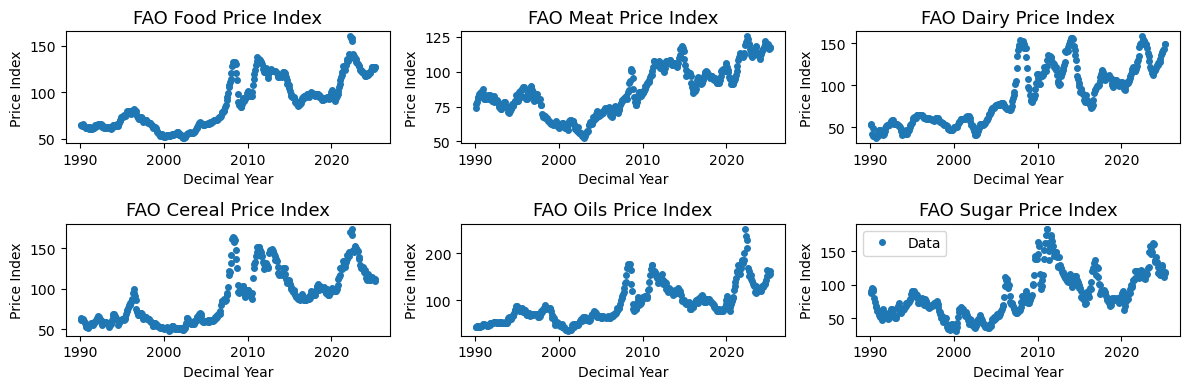

In [200]:
fig , ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(12,4))



ax1.plot(date, f_i, 'o', markersize=4, label=r'Data')
ax1.set_xlabel('Decimal Year', fontsize=10)
ax1.set_ylabel(r'Price Index', fontsize=10)
ax1.set_title('FAO Food Price Index', fontsize=13)

ax2.plot(date, meat, 'o', markersize=4, label=r'Data')
ax2.set_xlabel('Decimal Year', fontsize=10)
ax2.set_ylabel(r'Price Index', fontsize=10)
ax2.set_title('FAO Meat Price Index', fontsize=13)

ax3.plot(date, dairy, 'o', markersize=4, label=r'Data')
ax3.set_xlabel('Decimal Year', fontsize=10)
ax3.set_ylabel(r'Price Index', fontsize=10)
ax3.set_title('FAO Dairy Price Index', fontsize=13)

ax4.plot(date, cereals, 'o', markersize=4, label=r'Data')
ax4.set_xlabel('Decimal Year', fontsize=10)
ax4.set_ylabel(r'Price Index', fontsize=10)
ax4.set_title('FAO Cereal Price Index', fontsize=13)

ax5.plot(date, oils, 'o', markersize=4, label=r'Data')
ax5.set_xlabel('Decimal Year', fontsize=10)
ax5.set_ylabel(r'Price Index', fontsize=10)
ax5.set_title('FAO Oils Price Index', fontsize=13)

ax6.plot(date, sugar, 'o', markersize=4, label=r'Data')
ax6.set_xlabel('Decimal Year', fontsize=10)
ax6.set_ylabel(r'Price Index', fontsize=10)
ax6.set_title('FAO Sugar Price Index', fontsize=13)

plt.legend()
fig.tight_layout()
plt.show()


The same Long Short-Term Memory (LSTM) model can also be employed to forecast the temporal evolution of price dynamics, capturing intricate patterns and trends over time.

## Food Price Index

In [226]:

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(f_i.values.reshape(-1, 1))

look_back = 25 
n_future = 300  

# Create sequences (multi-step target)
X, y = [], []
for i in range(len(data_scaled) - look_back - n_future):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back:i + look_back + n_future])

X = np.array(X)
y = np.array(y)

X_aug, y_aug = augment_with_gaussian_noise(data_scaled, num_augmentations=5)
print(X_aug.shape, y_aug.shape)

# Combine original and augmented data
X_combined = np.concatenate([X, X_aug])
y_combined = np.concatenate([y, y_aug])

# Split into train/val/test with random_state
train_size = 0.7  # 70% for training
val_size = 0.15   # 15% for validation
test_size = 0.15  # 15% for test

# First split to get the train and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=(val_size + test_size), random_state=42)

# Then split the temporary data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=42)


(2475, 25, 1) (2475, 300, 1)


(2475, 25, 1) (2475, 300, 1)


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


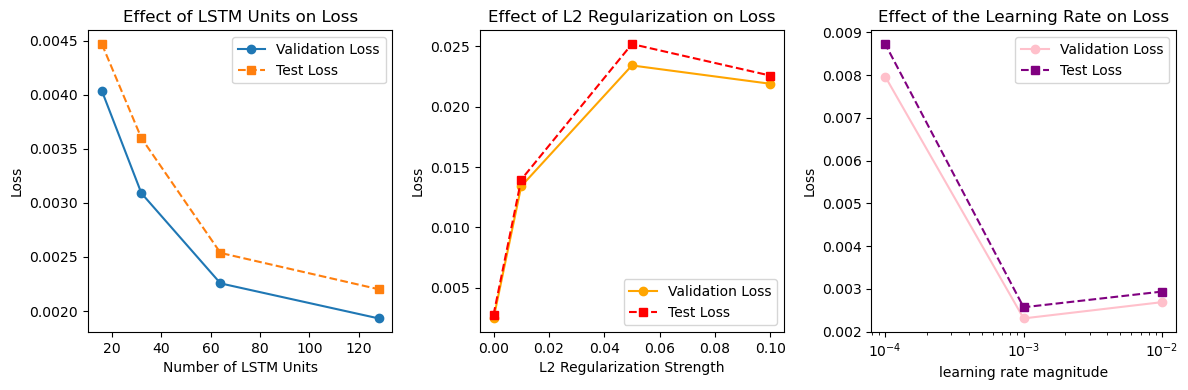

In [125]:

# Hyperparameter ranges
units_list = [16, 32, 64, 128]
reg_list = [0.0, 0.01, 0.05, 0.1]
alpha_list = [1e-2, 1e-3, 1e-4]

# Store results
# Clear all previous results
units_losses = []
units_test_losses = []
reg_losses = []
reg_test_losses = []
alpha_losses = []
alpha_test_losses = []

# Sweep LSTM units
for units in units_list:
    model = Sequential([
        LSTM(units, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(units, activation="relu"),
        Dense(n_future)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    units_losses.append(val_loss)
    units_test_losses.append(test_loss)

# Sweep regularization strengths
for reg in reg_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(reg)),
        LSTM(64, activation="relu", kernel_regularizer=regularizers.l2(reg)),
        Dense(n_future, kernel_regularizer=regularizers.l2(reg))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    reg_losses.append(val_loss)
    reg_test_losses.append(test_loss)

# Sweep learning rate
for alpha in alpha_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(64, activation="relu"),
        Dense(n_future)
        ])
    model.compile(optimizer=Adam(learning_rate=alpha), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    alpha_losses.append(val_loss)
    alpha_test_losses.append(test_loss)
                   
# Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Neurons
ax1.plot(units_list, units_losses, marker='o', label='Validation Loss')
ax1.plot(units_list, units_test_losses, marker='s', linestyle='--', label='Test Loss')
ax1.set_title("Effect of LSTM Units on Loss")
ax1.set_xlabel("Number of LSTM Units")
ax1.set_ylabel("Loss")
ax1.legend()

# Regularization
ax2.plot(reg_list, reg_losses, marker='o', color='orange', label='Validation Loss')
ax2.plot(reg_list, reg_test_losses, marker='s', linestyle='--', color='red', label='Test Loss')
ax2.set_title("Effect of L2 Regularization on Loss")
ax2.set_xlabel("L2 Regularization Strength")
ax2.set_ylabel("Loss")
ax2.legend()

# learning rate
ax3.plot(alpha_list, alpha_losses, marker='o', color='pink', label='Validation Loss')
ax3.plot(alpha_list, alpha_test_losses, marker='s', linestyle='--', color='purple', label='Test Loss')
ax3.set_title("Effect of the Learning Rate on Loss")
ax3.set_xlabel("learning rate magnitude")
ax3.set_ylabel("Loss")
ax3.set_xscale('log')
ax3.legend()

plt.tight_layout()
plt.show()

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


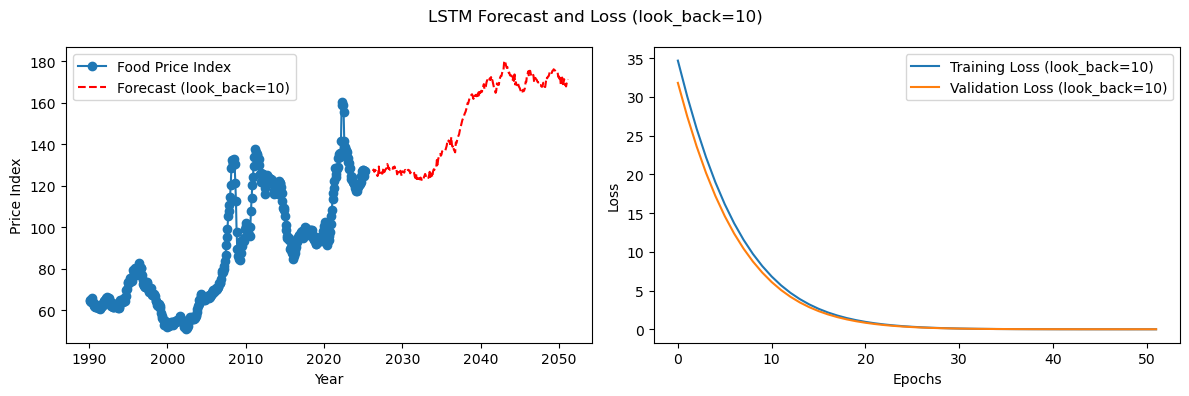

[look_back=10] Final Validation Loss: 0.0298, Test Loss: 0.0265


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


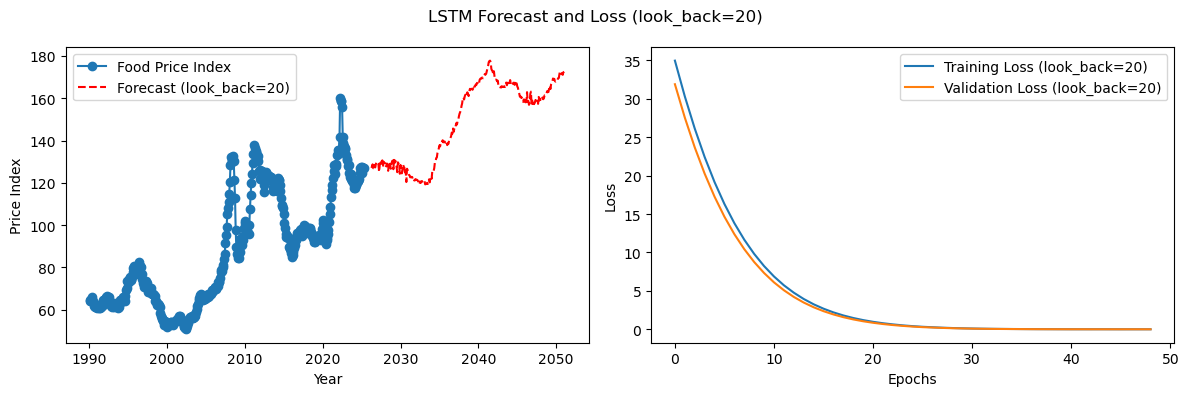

[look_back=20] Final Validation Loss: 0.0274, Test Loss: 0.0291


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


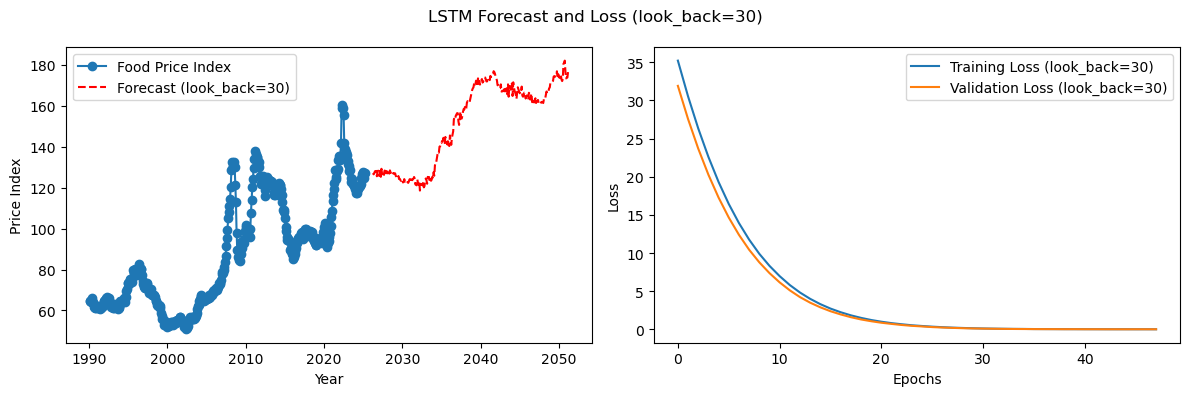

[look_back=30] Final Validation Loss: 0.0268, Test Loss: 0.0288


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


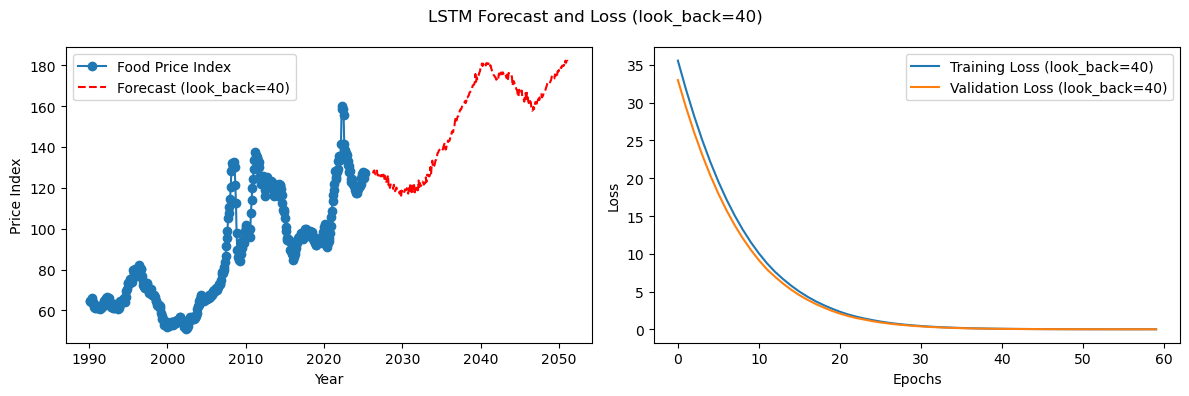

[look_back=40] Final Validation Loss: 0.0226, Test Loss: 0.0245


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


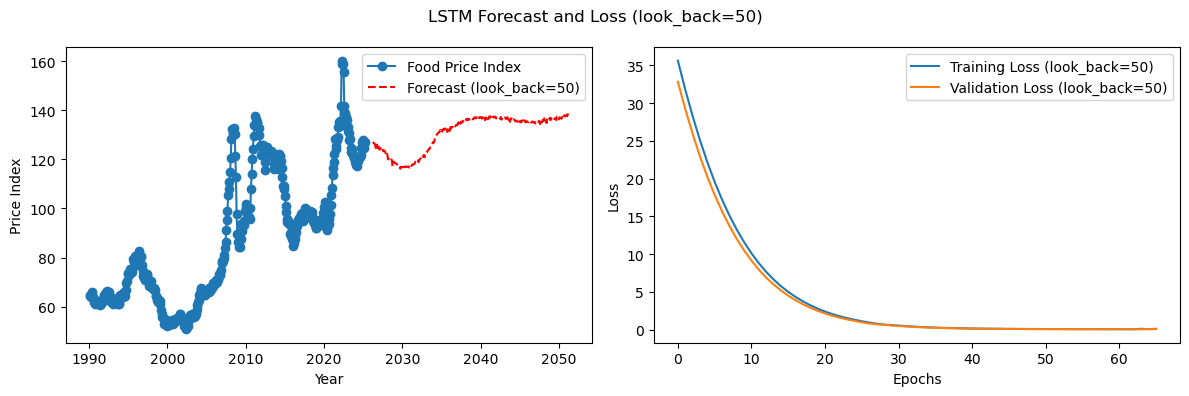

[look_back=50] Final Validation Loss: 0.1271, Test Loss: 0.0692


In [232]:
look_back_list =  [10, 20, 30, 40, 50]  # Example values
n_future = 300  # months

for look_back in look_back_list:
    # Recreate sequences for current look_back
    X, y = [], []
    for i in range(len(data_scaled) - look_back - n_future):
        X.append(data_scaled[i:i + look_back])
        y.append(data_scaled[i + look_back:i + look_back + n_future])
    X = np.array(X)
    y = np.array(y)

    # Train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Model definition
    model = Sequential([
        LSTM(120, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(0.1)),
        LSTM(120, activation="relu", kernel_regularizer=regularizers.l2(0.1)),
        Dense(n_future, kernel_regularizer=regularizers.l2(0.1))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Forecast using the last sequence
    last_sequence = data_scaled[-look_back:]
    last_sequence = last_sequence.reshape(1, look_back, 1)
    future_preds = model.predict(last_sequence)[0]
    future_preds = scaler.inverse_transform(future_preds.reshape(-1, 1))

    # Generate future timeline
    years_future = np.arange(max(date) + 1, max(date) + 1 + n_future/12 , step=1/12)

    # Plot forecast and losses
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'LSTM Forecast and Loss (look_back={look_back})')

    # Forecast plot with dynamic label
    ax1.plot(date, f_i, label="Food Price Index", marker="o")
    ax1.plot(
        years_future,
        future_preds.flatten() + (f_i.iloc[-1] - future_preds[0]),
        label=f"Forecast (look_back={look_back})",
        linestyle="dashed",
        color="red"
    )
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Price Index")
    ax1.legend()
    
    # Loss plot with dynamic labels
    ax2.plot(history.history['loss'], label=f'Training Loss (look_back={look_back})')
    ax2.plot(history.history['val_loss'], label=f'Validation Loss (look_back={look_back})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Optionally evaluate on test set
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"[look_back={look_back}] Final Validation Loss: {history.history['val_loss'][-1]:.4f}, Test Loss: {test_loss:.4f}")

## Meat Price Index

In [234]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(meat.values.reshape(-1, 1))

look_back = 25 
n_future = 300  # Predict 300 months (25 years) ahead

# Create sequences (multi-step target)
X, y = [], []
for i in range(len(data_scaled) - look_back - n_future):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back:i + look_back + n_future])

X = np.array(X)
y = np.array(y)

X_aug, y_aug = augment_with_gaussian_noise(data_scaled, num_augmentations=5)
print(X_aug.shape, y_aug.shape)

# Combine original and augmented data
X_combined = np.concatenate([X, X_aug])
y_combined = np.concatenate([y, y_aug])

# Split into train/val/test with random_state
train_size = 0.7  # 70% for training
val_size = 0.15   # 15% for validation
test_size = 0.15  # 15% for test

# First split to get the train and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=(val_size + test_size), random_state=42)

# Then split the temporary data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=42)


(2475, 25, 1) (2475, 300, 1)


(2475, 25, 1) (2475, 300, 1)


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


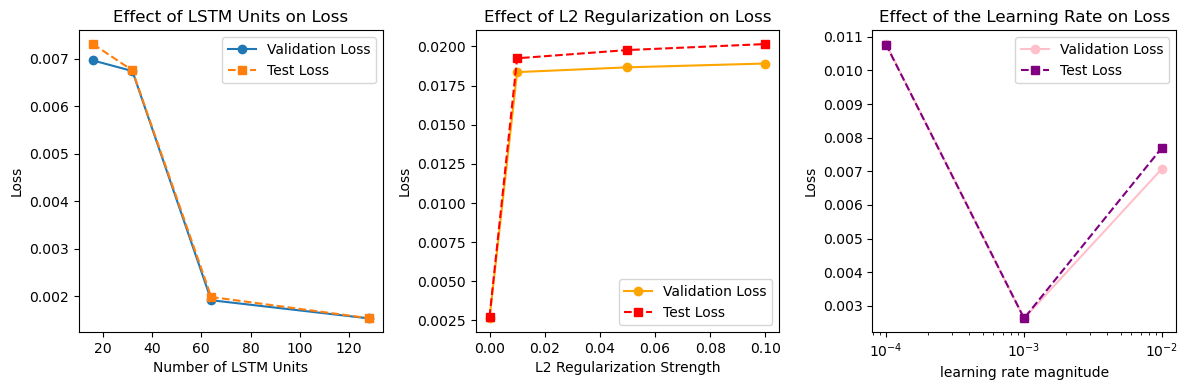

In [131]:

# Hyperparameter ranges
units_list = [16, 32, 64, 128]
reg_list = [0.0, 0.01, 0.05, 0.1]
alpha_list = [1e-2, 1e-3, 1e-4]

# Store results
# Clear all previous results
units_losses = []
units_test_losses = []
reg_losses = []
reg_test_losses = []
alpha_losses = []
alpha_test_losses = []

# Sweep LSTM units
for units in units_list:
    model = Sequential([
        LSTM(units, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(units, activation="relu"),
        Dense(n_future)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    units_losses.append(val_loss)
    units_test_losses.append(test_loss)

# Sweep regularization strengths
for reg in reg_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(reg)),
        LSTM(64, activation="relu", kernel_regularizer=regularizers.l2(reg)),
        Dense(n_future, kernel_regularizer=regularizers.l2(reg))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    reg_losses.append(val_loss)
    reg_test_losses.append(test_loss)

# Sweep learning rate
for alpha in alpha_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(64, activation="relu"),
        Dense(n_future)
        ])
    model.compile(optimizer=Adam(learning_rate=alpha), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    alpha_losses.append(val_loss)
    alpha_test_losses.append(test_loss)
                   
# Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Neurons
ax1.plot(units_list, units_losses, marker='o', label='Validation Loss')
ax1.plot(units_list, units_test_losses, marker='s', linestyle='--', label='Test Loss')
ax1.set_title("Effect of LSTM Units on Loss")
ax1.set_xlabel("Number of LSTM Units")
ax1.set_ylabel("Loss")
ax1.legend()

# Regularization
ax2.plot(reg_list, reg_losses, marker='o', color='orange', label='Validation Loss')
ax2.plot(reg_list, reg_test_losses, marker='s', linestyle='--', color='red', label='Test Loss')
ax2.set_title("Effect of L2 Regularization on Loss")
ax2.set_xlabel("L2 Regularization Strength")
ax2.set_ylabel("Loss")
ax2.legend()

# learning rate
ax3.plot(alpha_list, alpha_losses, marker='o', color='pink', label='Validation Loss')
ax3.plot(alpha_list, alpha_test_losses, marker='s', linestyle='--', color='purple', label='Test Loss')
ax3.set_title("Effect of the Learning Rate on Loss")
ax3.set_xlabel("learning rate magnitude")
ax3.set_ylabel("Loss")
ax3.set_xscale('log')
ax3.legend()

plt.tight_layout()
plt.show()

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


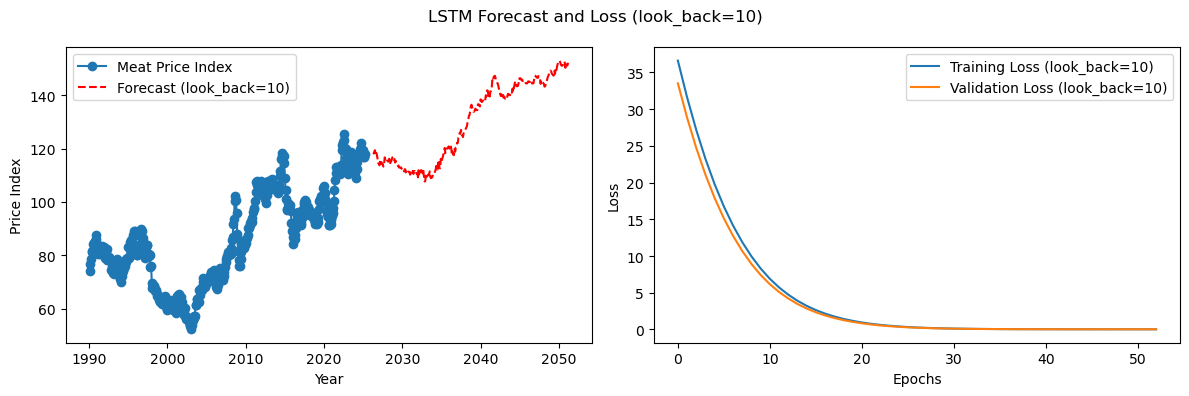

[look_back=10] Final Validation Loss: 0.0276, Test Loss: 0.0254


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


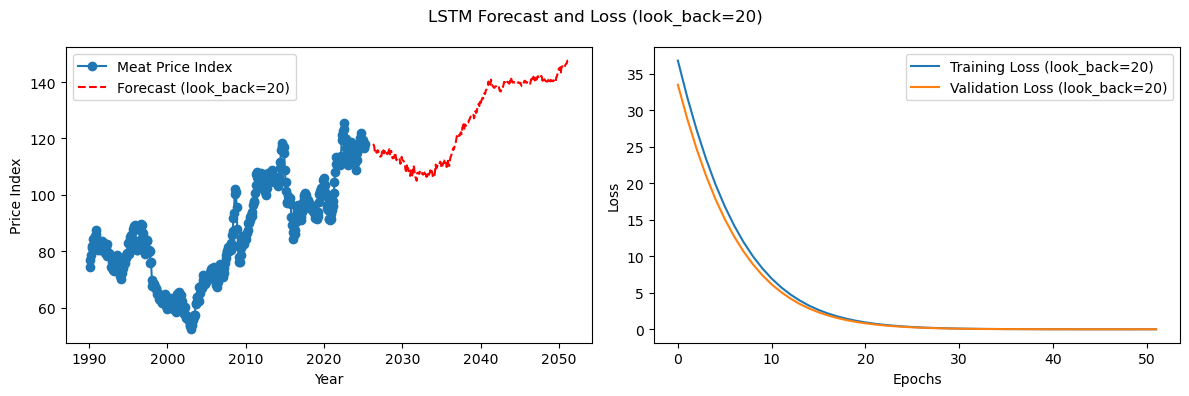

[look_back=20] Final Validation Loss: 0.0262, Test Loss: 0.0229


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


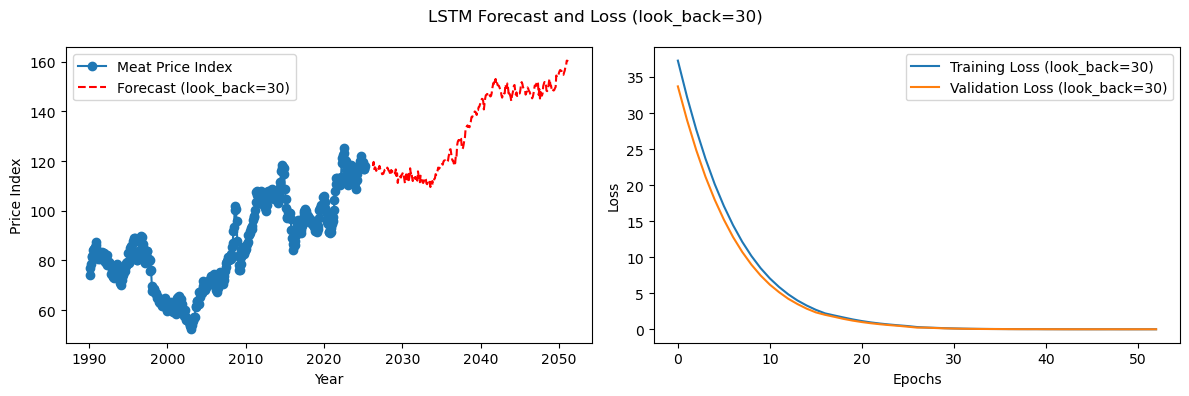

[look_back=30] Final Validation Loss: 0.0253, Test Loss: 0.0278


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


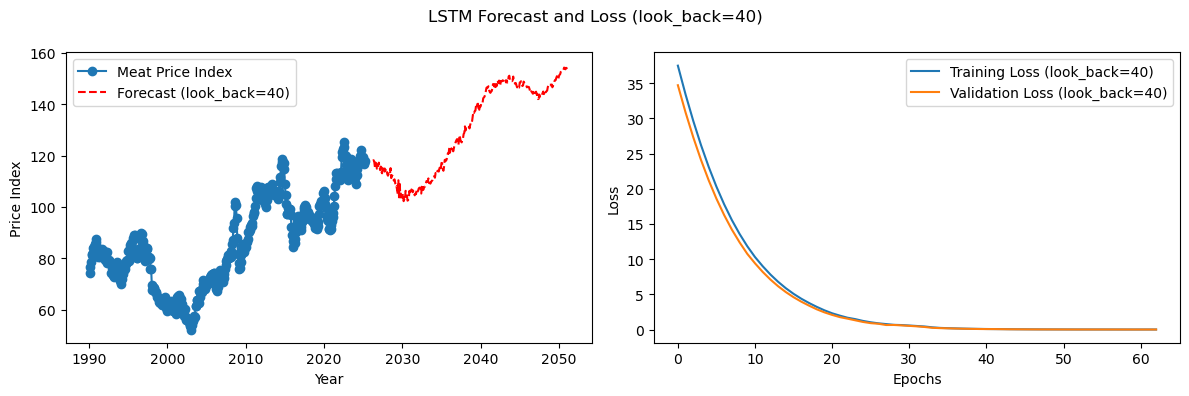

[look_back=40] Final Validation Loss: 0.0205, Test Loss: 0.0215


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


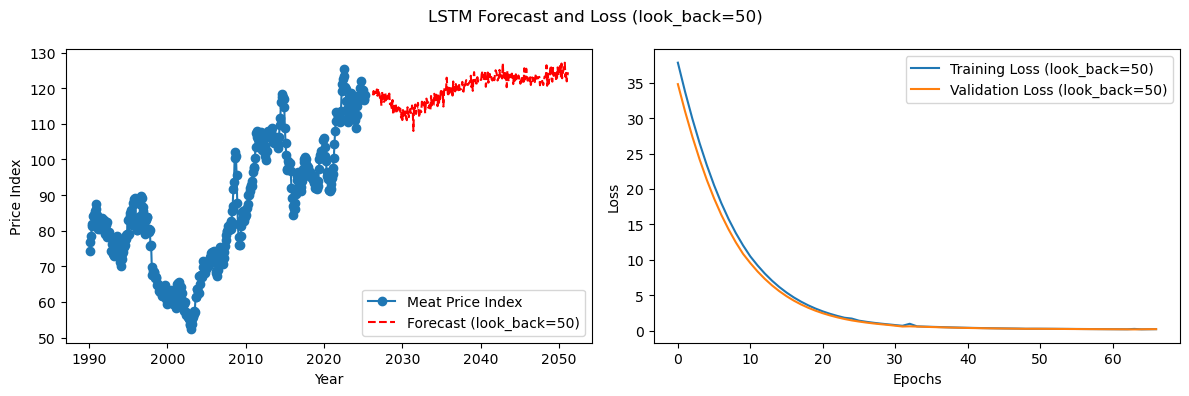

[look_back=50] Final Validation Loss: 0.2164, Test Loss: 0.1908


In [236]:
look_back_list =  [10, 20, 30, 40, 50]  # Example values
n_future = 300  # months

for look_back in look_back_list:
    # Recreate sequences for current look_back
    X, y = [], []
    for i in range(len(data_scaled) - look_back - n_future):
        X.append(data_scaled[i:i + look_back])
        y.append(data_scaled[i + look_back:i + look_back + n_future])
    X = np.array(X)
    y = np.array(y)

    # Train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Model definition
    model = Sequential([
        LSTM(128, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(0.1)),
        LSTM(128, activation="relu", kernel_regularizer=regularizers.l2(0.1)),
        Dense(n_future, kernel_regularizer=regularizers.l2(0.1))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Forecast using the last sequence
    last_sequence = data_scaled[-look_back:]
    last_sequence = last_sequence.reshape(1, look_back, 1)
    future_preds = model.predict(last_sequence)[0]
    future_preds = scaler.inverse_transform(future_preds.reshape(-1, 1))

    # Generate future timeline
    years_future = np.arange(max(date) + 1, max(date) + 1 + n_future/12 , step=1/12)

    # Plot forecast and losses
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'LSTM Forecast and Loss (look_back={look_back})')

    # Forecast plot with dynamic label
    ax1.plot(date, meat, label="Meat Price Index", marker="o")
    ax1.plot(
        years_future,
        future_preds.flatten() + (meat.iloc[-1] - future_preds[0]),
        label=f"Forecast (look_back={look_back})",
        linestyle="dashed",
        color="red"
    )
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Price Index")
    ax1.legend()
    
    # Loss plot with dynamic labels
    ax2.plot(history.history['loss'], label=f'Training Loss (look_back={look_back})')
    ax2.plot(history.history['val_loss'], label=f'Validation Loss (look_back={look_back})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Optionally evaluate on test set
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"[look_back={look_back}] Final Validation Loss: {history.history['val_loss'][-1]:.4f}, Test Loss: {test_loss:.4f}")

## Cereals Price Index

In [238]:

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(cereals.values.reshape(-1, 1))

look_back = 25 
n_future = 300  # Predict 300 months (25 years) ahead

# Create sequences (multi-step target)
X, y = [], []
for i in range(len(data_scaled) - look_back - n_future):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back:i + look_back + n_future])

X = np.array(X)
y = np.array(y)


X_aug, y_aug = augment_with_gaussian_noise(data_scaled, num_augmentations=5)
print(X_aug.shape, y_aug.shape)

# Combine original and augmented data
X_combined = np.concatenate([X, X_aug])
y_combined = np.concatenate([y, y_aug])

# Split into train/val/test with random_state
train_size = 0.7  # 70% for training
val_size = 0.15   # 15% for validation
test_size = 0.15  # 15% for test

# First split to get the train and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=(val_size + test_size), random_state=42)

# Then split the temporary data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=42)


(2475, 25, 1) (2475, 300, 1)


(2475, 25, 1) (2475, 300, 1)


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


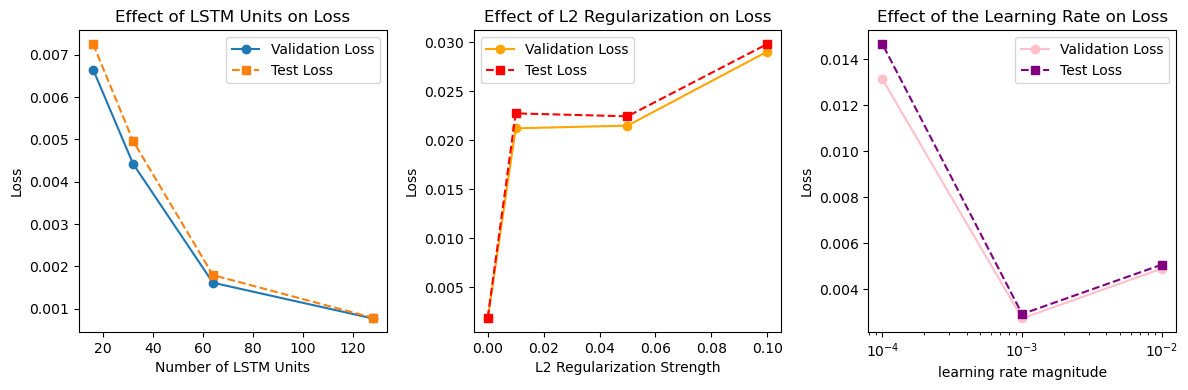

In [135]:

# Hyperparameter ranges
units_list = [16, 32, 64, 128]
reg_list = [0.0, 0.01, 0.05, 0.1]
alpha_list = [1e-2, 1e-3, 1e-4]

# Store results
# Clear all previous results
units_losses = []
units_test_losses = []
reg_losses = []
reg_test_losses = []
alpha_losses = []
alpha_test_losses = []

# Sweep LSTM units
for units in units_list:
    model = Sequential([
        LSTM(units, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(units, activation="relu"),
        Dense(n_future)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    units_losses.append(val_loss)
    units_test_losses.append(test_loss)

# Sweep regularization strengths
for reg in reg_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(reg)),
        LSTM(64, activation="relu", kernel_regularizer=regularizers.l2(reg)),
        Dense(n_future, kernel_regularizer=regularizers.l2(reg))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    reg_losses.append(val_loss)
    reg_test_losses.append(test_loss)

# Sweep learning rate
for alpha in alpha_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(64, activation="relu"),
        Dense(n_future)
        ])
    model.compile(optimizer=Adam(learning_rate=alpha), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    alpha_losses.append(val_loss)
    alpha_test_losses.append(test_loss)
                   
# Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Neurons
ax1.plot(units_list, units_losses, marker='o', label='Validation Loss')
ax1.plot(units_list, units_test_losses, marker='s', linestyle='--', label='Test Loss')
ax1.set_title("Effect of LSTM Units on Loss")
ax1.set_xlabel("Number of LSTM Units")
ax1.set_ylabel("Loss")
ax1.legend()

# Regularization
ax2.plot(reg_list, reg_losses, marker='o', color='orange', label='Validation Loss')
ax2.plot(reg_list, reg_test_losses, marker='s', linestyle='--', color='red', label='Test Loss')
ax2.set_title("Effect of L2 Regularization on Loss")
ax2.set_xlabel("L2 Regularization Strength")
ax2.set_ylabel("Loss")
ax2.legend()

# learning rate
ax3.plot(alpha_list, alpha_losses, marker='o', color='pink', label='Validation Loss')
ax3.plot(alpha_list, alpha_test_losses, marker='s', linestyle='--', color='purple', label='Test Loss')
ax3.set_title("Effect of the Learning Rate on Loss")
ax3.set_xlabel("learning rate magnitude")
ax3.set_ylabel("Loss")
ax3.set_xscale('log')
ax3.legend()

plt.tight_layout()
plt.show()

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


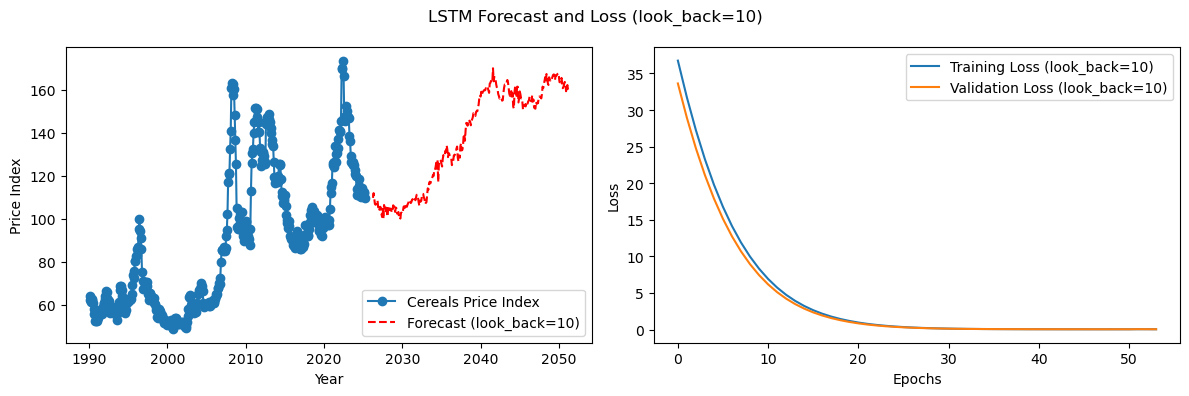

[look_back=10] Final Validation Loss: 0.0386, Test Loss: 0.0350


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


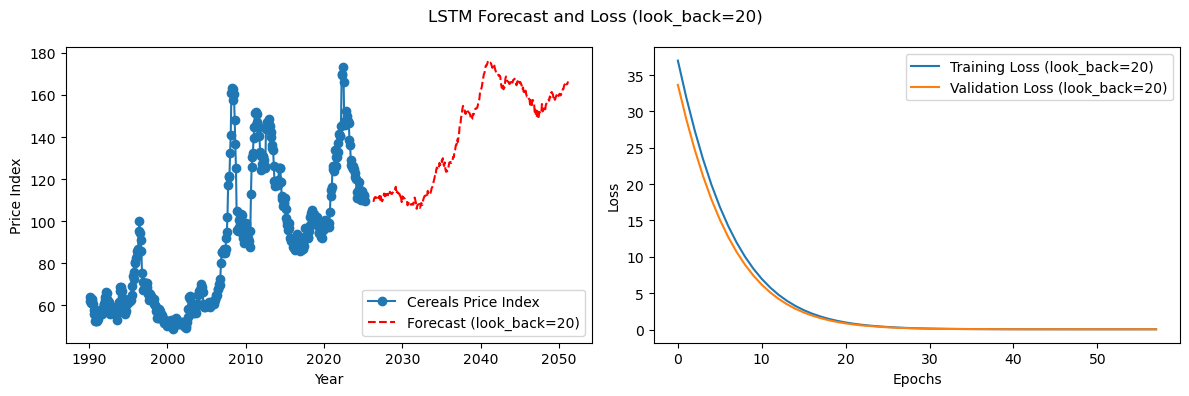

[look_back=20] Final Validation Loss: 0.0320, Test Loss: 0.0326


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


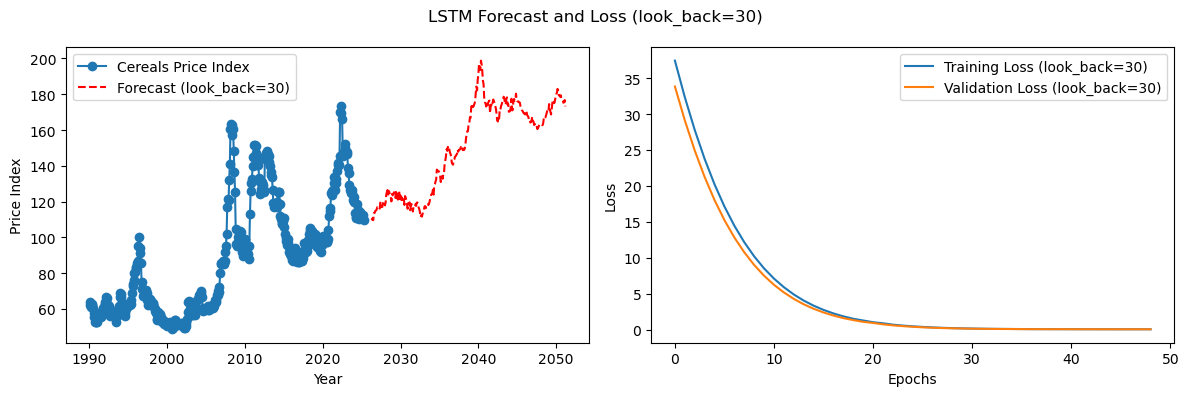

[look_back=30] Final Validation Loss: 0.0329, Test Loss: 0.0363


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


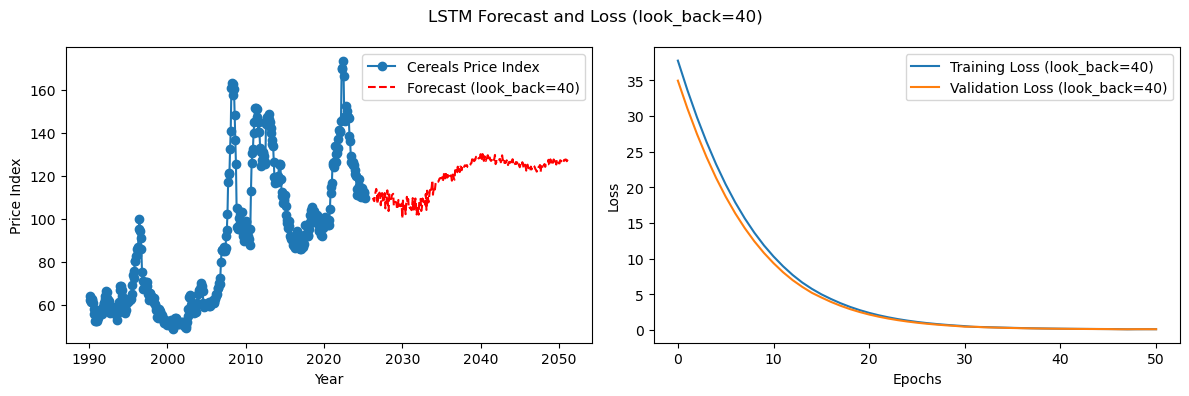

[look_back=40] Final Validation Loss: 0.1003, Test Loss: 0.0869


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


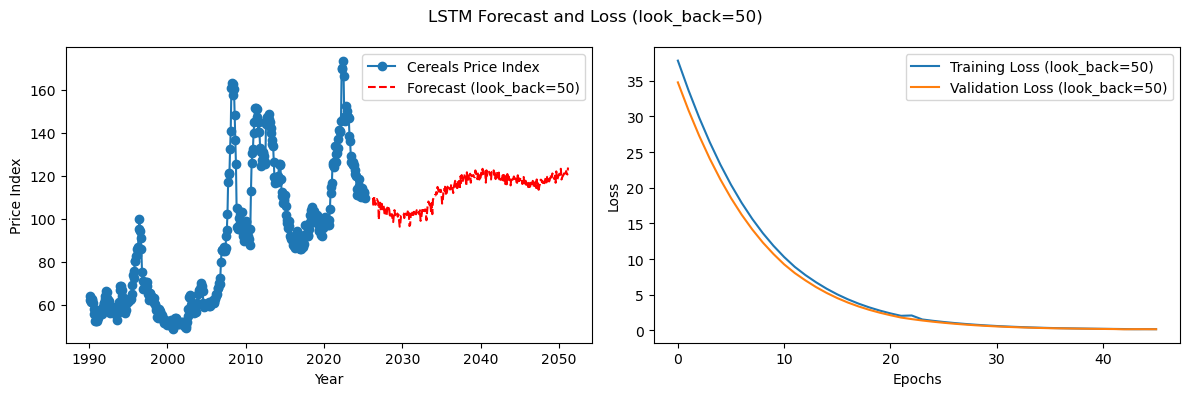

[look_back=50] Final Validation Loss: 0.1762, Test Loss: 0.1734


In [242]:
look_back_list =  [10, 20, 30, 40, 50]  # Example values
n_future = 300  # months

for look_back in look_back_list:
    # Recreate sequences for current look_back
    X, y = [], []
    for i in range(len(data_scaled) - look_back - n_future):
        X.append(data_scaled[i:i + look_back])
        y.append(data_scaled[i + look_back:i + look_back + n_future])
    X = np.array(X)
    y = np.array(y)

    # Train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Model definition
    model = Sequential([
        LSTM(129, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(0.1)),
        LSTM(129, activation="relu", kernel_regularizer=regularizers.l2(0.1)),
        Dense(n_future, kernel_regularizer=regularizers.l2(0.1))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Forecast using the last sequence
    last_sequence = data_scaled[-look_back:]
    last_sequence = last_sequence.reshape(1, look_back, 1)
    future_preds = model.predict(last_sequence)[0]
    future_preds = scaler.inverse_transform(future_preds.reshape(-1, 1))

    # Generate future timeline
    years_future = np.arange(max(date) + 1, max(date) + 1 + n_future/12 , step=1/12)

    # Plot forecast and losses
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'LSTM Forecast and Loss (look_back={look_back})')

    # Forecast plot with dynamic label
    ax1.plot(date, cereals, label="Cereals Price Index", marker="o")
    ax1.plot(
        years_future,
        future_preds.flatten() + (cereals.iloc[-1] - future_preds[0]),
        label=f"Forecast (look_back={look_back})",
        linestyle="dashed",
        color="red"
    )
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Price Index")
    ax1.legend()
    
    # Loss plot with dynamic labels
    ax2.plot(history.history['loss'], label=f'Training Loss (look_back={look_back})')
    ax2.plot(history.history['val_loss'], label=f'Validation Loss (look_back={look_back})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Optionally evaluate on test set
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"[look_back={look_back}] Final Validation Loss: {history.history['val_loss'][-1]:.4f}, Test Loss: {test_loss:.4f}")

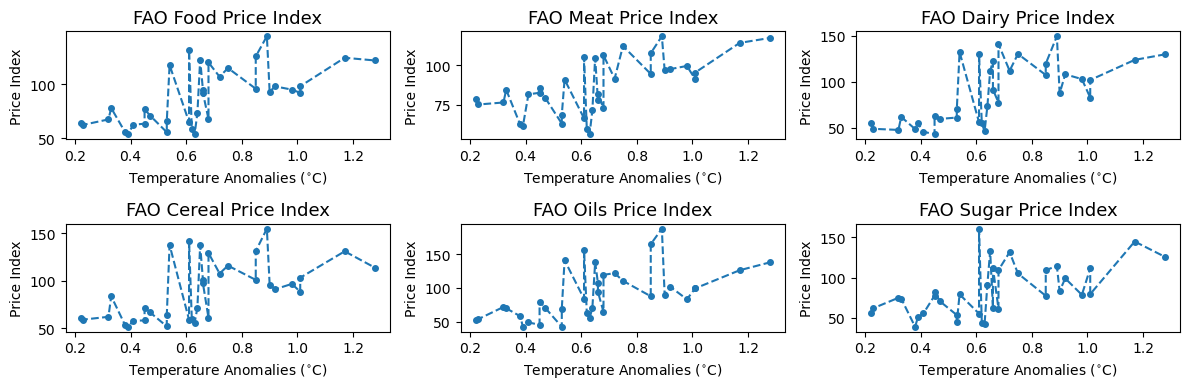

Year  Tempertature Anomalies (C)  Smooth Tempertature Anomalies (C)  \
2  1992                        0.22                               0.33   
3  1993                        0.23                               0.33   
4  1994                        0.32                               0.34   
6  1996                        0.33                               0.40   
9  1999                        0.38                               0.47   

   Food Price Index       Meat      Dairy    Cereals       Oils      Sugar  
2         64.225000  78.400000  54.800000  60.958333  52.993333  56.025000  
3         62.258333  75.025000  48.608333  59.025000  53.965833  62.025000  
4         67.266667  76.300000  47.408333  61.933333  71.867500  74.950000  
6         77.816667  84.358333  61.625000  83.650000  69.935833  73.991667  
9         55.391667  62.425000  48.308333  53.125000  58.225833  38.800000

In [264]:
df_food = df_food.apply(pd.to_numeric, errors='coerce')

# Now perform the groupby operation on the numeric dataframe

new_df_food = df_food.groupby(by=['Year']).mean()
new_df_food = new_df_food.drop(columns=['Date','Month','Decimal Date'])
new_df_food.head()
new_df_food = new_df_food.reset_index()
new_df_food.head()

merged_df = pd.merge(df_T, new_df_food, on='Year')
merged_df = merged_df[(merged_df['Year']>=1990) &(merged_df['Year']<2025)]
merged_df = merged_df.sort_values(by='Tempertature Anomalies (C)')


T_food = merged_df['Tempertature Anomalies (C)']

#Food Price Index temperature dependence
f_i_T = merged_df['Food Price Index']

# #meat temperature dependence
meat_T = merged_df['Meat']

# #diary temperature dependence
dairy_T = merged_df['Dairy']

# #diary temperature dependence
cereals_T = merged_df['Cereals']

# #diary temperature dependence
oils_T = merged_df['Oils']

# #diary temperature dependence
sugar_T = merged_df['Sugar']

# #plot
fig , ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(12,4))



ax1.plot(T_food, f_i_T, '--o', markersize=4, label=r'Data')
ax1.set_xlabel(r"Temperature Anomalies ($^{\circ}$C)", fontsize=10)
ax1.set_ylabel(r'Price Index', fontsize=10)
ax1.set_title('FAO Food Price Index', fontsize=13)

ax2.plot(T_food, meat_T, '--o', markersize=4, label=r'Data')
ax2.set_xlabel(r"Temperature Anomalies ($^{\circ}$C)", fontsize=10)
ax2.set_ylabel(r'Price Index', fontsize=10)
ax2.set_title('FAO Meat Price Index', fontsize=13)

ax3.plot(T_food, dairy_T, '--o', markersize=4, label=r'Data')
ax3.set_xlabel(r"Temperature Anomalies ($^{\circ}$C)", fontsize=10)
ax3.set_ylabel(r'Price Index', fontsize=10)
ax3.set_title('FAO Dairy Price Index', fontsize=13)

ax4.plot(T_food, cereals_T, '--o', markersize=4, label=r'Data')
ax4.set_xlabel(r"Temperature Anomalies ($^{\circ}$C)", fontsize=10)
ax4.set_ylabel(r'Price Index', fontsize=10)
ax4.set_title('FAO Cereal Price Index', fontsize=13)

ax5.plot(T_food, oils_T, '--o', markersize=4, label=r'Data')
ax5.set_xlabel(r"Temperature Anomalies ($^{\circ}$C)", fontsize=10)
ax5.set_ylabel(r'Price Index', fontsize=10)
ax5.set_title('FAO Oils Price Index', fontsize=13)

ax6.plot(T_food, sugar_T, '--o', markersize=4, label=r'Data')
ax6.set_xlabel(r"Temperature Anomalies ($^{\circ}$C)", fontsize=10)
ax6.set_ylabel(r'Price Index', fontsize=10)
ax6.set_title('FAO Sugar Price Index', fontsize=13)


fig.tight_layout()
plt.show()

merged_df.head()

<Axes: >

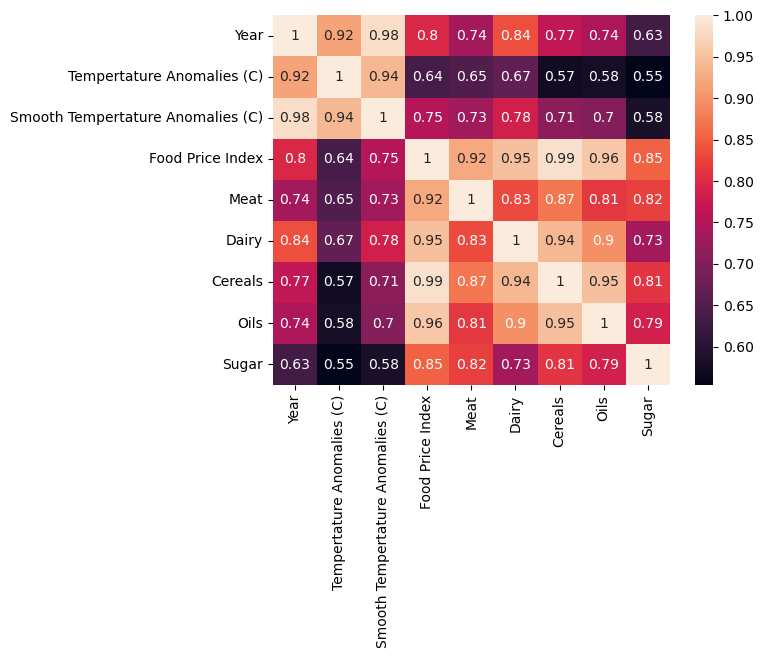

In [204]:
sns.heatmap(merged_df.corr(), annot=True)

The heatmap displays the Pearson correlation matrix, which measures the strength and direction of linear relationships between the variables in the dataset. Correlation coefficients range from -1 to +1, where values close to +1 indicate a strong positive linear relationship, values near -1 represent a strong negative linear relationship, and values around 0 suggest little to no linear correlation. This visualization helps identify potential dependencies or patterns among the variables. 

As expected, there is a strong positive correlation between the 'Year' and 'Temperature Anomalies (°C)', with a coefficient of 0.92. This reflects the clear upward trend in global temperatures over time, consistent with the ongoing impacts of climate change. Among the food categories analyzed, meat and dairy products exhibit the highest correlation with temperature anomalies—excluding the general variable 'Food Price Index'. This suggests that these two sectors are particularly sensitive to climate-related factors and may be more directly influenced by global warming

## Forecasting the Food Price Index Based on Global Temperature Trends

In [246]:

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(meat_T.values.reshape(-1, 1))

look_back = 5 
n_future = 3  

# Create sequences (multi-step target)
X, y = [], []
for i in range(len(data_scaled) - look_back - n_future):
    X.append(data_scaled[i:i + look_back])
    y.append(data_scaled[i + look_back:i + look_back + n_future])

X = np.array(X)
y = np.array(y)


X_aug, y_aug = augment_with_gaussian_noise(data_scaled, num_augmentations=5)
print(X_aug.shape, y_aug.shape)

# Combine original and augmented data
X_combined = np.concatenate([X, X_aug])
y_combined = np.concatenate([y, y_aug])

# Split into train/val/test with random_state
train_size = 0.7  # 70% for training
val_size = 0.15   # 15% for validation
test_size = 0.15  # 15% for test

# First split to get the train and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=(val_size + test_size), random_state=42)

# Then split the temporary data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=42)


(1120, 5, 1) (1120, 3, 1)


(1120, 5, 1) (1120, 3, 1)


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


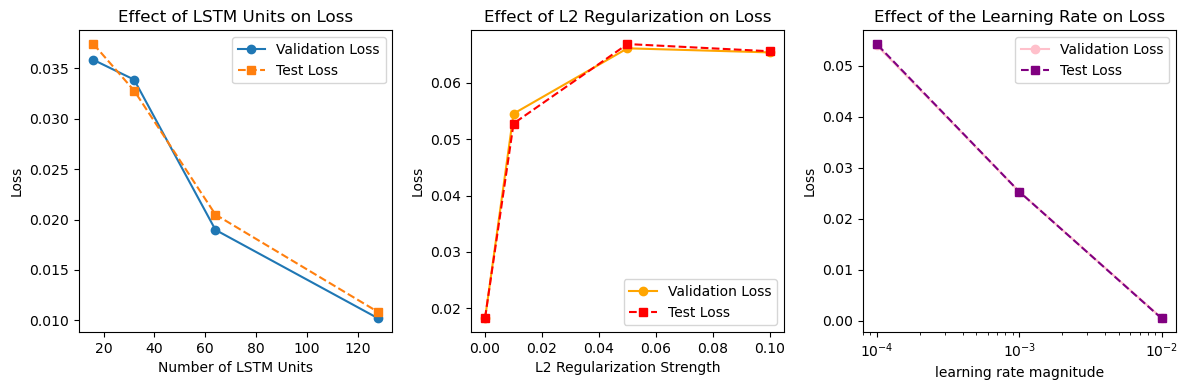

In [153]:

# Hyperparameter ranges
units_list = [16, 32, 64, 128]
reg_list = [0.0, 0.01, 0.05, 0.1]
alpha_list = [1e-2, 1e-3, 1e-4]

# Store results
# Clear all previous results
units_losses = []
units_test_losses = []
reg_losses = []
reg_test_losses = []
alpha_losses = []
alpha_test_losses = []

# Sweep LSTM units
for units in units_list:
    model = Sequential([
        LSTM(units, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(units, activation="relu"),
        Dense(n_future)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    units_losses.append(val_loss)
    units_test_losses.append(test_loss)

# Sweep regularization strengths
for reg in reg_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(reg)),
        LSTM(64, activation="relu", kernel_regularizer=regularizers.l2(reg)),
        Dense(n_future, kernel_regularizer=regularizers.l2(reg))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    reg_losses.append(val_loss)
    reg_test_losses.append(test_loss)

# Sweep learning rate
for alpha in alpha_list:
    model = Sequential([
        LSTM(64, activation="relu", return_sequences=True, input_shape=(look_back, 1)),
        LSTM(64, activation="relu"),
        Dense(n_future)
        ])
    model.compile(optimizer=Adam(learning_rate=alpha), loss="mse")
    history = model.fit(X_train, y_train, epochs=30, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_loss = history.history["val_loss"][-1]
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    alpha_losses.append(val_loss)
    alpha_test_losses.append(test_loss)
                   
# Plotting results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Neurons
ax1.plot(units_list, units_losses, marker='o', label='Validation Loss')
ax1.plot(units_list, units_test_losses, marker='s', linestyle='--', label='Test Loss')
ax1.set_title("Effect of LSTM Units on Loss")
ax1.set_xlabel("Number of LSTM Units")
ax1.set_ylabel("Loss")
ax1.legend()

# Regularization
ax2.plot(reg_list, reg_losses, marker='o', color='orange', label='Validation Loss')
ax2.plot(reg_list, reg_test_losses, marker='s', linestyle='--', color='red', label='Test Loss')
ax2.set_title("Effect of L2 Regularization on Loss")
ax2.set_xlabel("L2 Regularization Strength")
ax2.set_ylabel("Loss")
ax2.legend()

# learning rate
ax3.plot(alpha_list, alpha_losses, marker='o', color='pink', label='Validation Loss')
ax3.plot(alpha_list, alpha_test_losses, marker='s', linestyle='--', color='purple', label='Test Loss')
ax3.set_title("Effect of the Learning Rate on Loss")
ax3.set_xlabel("learning rate magnitude")
ax3.set_ylabel("Loss")
ax3.set_xscale('log')
ax3.legend()

plt.tight_layout()
plt.show()

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


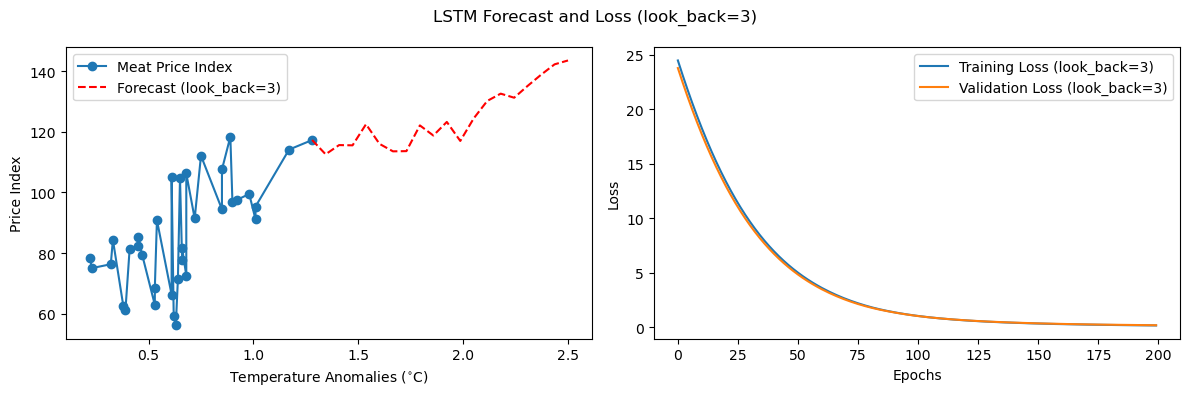

[look_back=3] Final Validation Loss: 0.1655, Test Loss: 0.1597


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


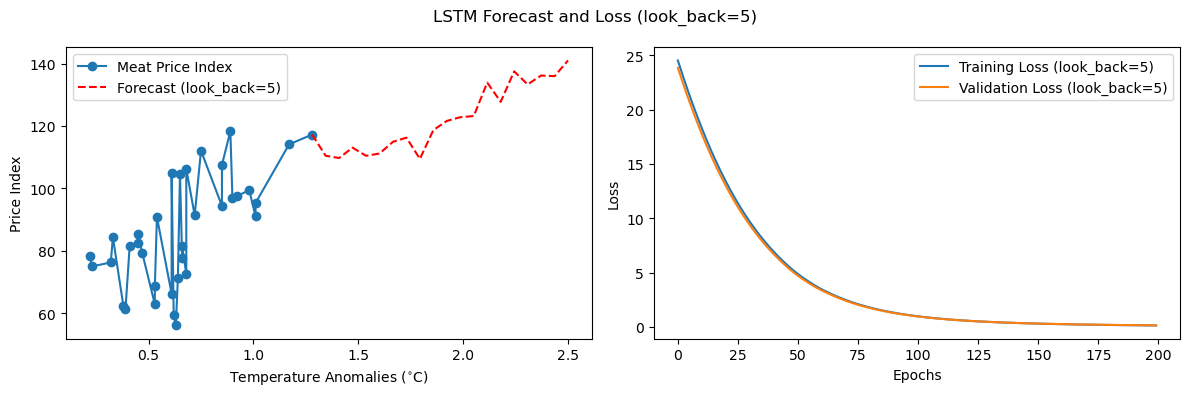

[look_back=5] Final Validation Loss: 0.1495, Test Loss: 0.1503


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


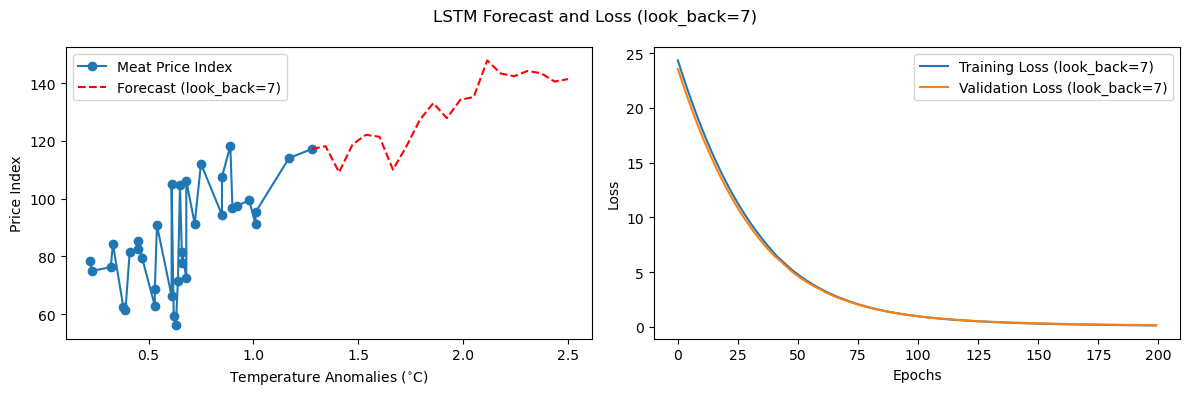

[look_back=7] Final Validation Loss: 0.1612, Test Loss: 0.1588


D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


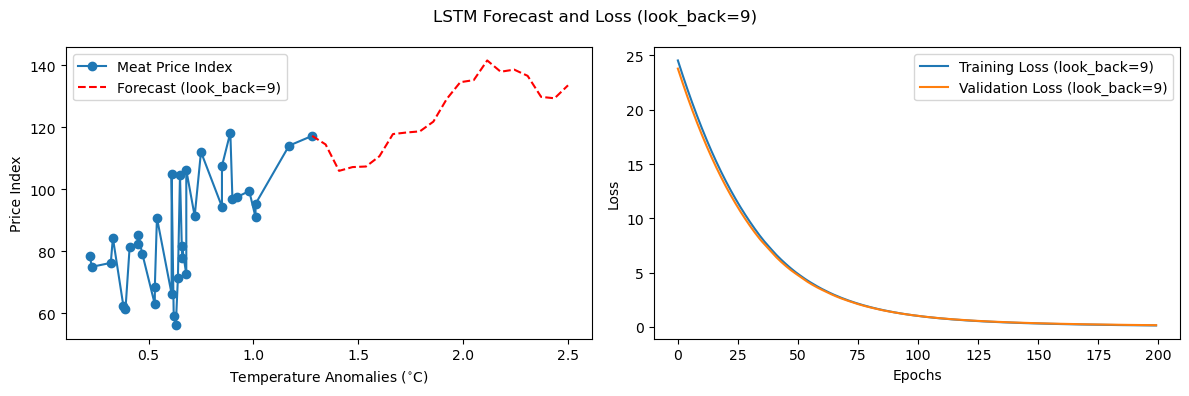

[look_back=9] Final Validation Loss: 0.1651, Test Loss: 0.1637


In [250]:
look_back_list =  [3,5,7,9]  # Example values
n_future = 20  # months

for look_back in look_back_list:
    # Recreate sequences for current look_back
    X, y = [], []
    for i in range(len(data_scaled) - look_back - n_future):
        X.append(data_scaled[i:i + look_back])
        y.append(data_scaled[i + look_back:i + look_back + n_future])
    X = np.array(X)
    y = np.array(y)

    # Train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Model definition
    model = Sequential([
        LSTM(128, activation="relu", return_sequences=True, input_shape=(look_back, 1),
             kernel_regularizer=regularizers.l2(0.1)),
        LSTM(128, activation="relu", kernel_regularizer=regularizers.l2(0.1)),
        Dense(n_future, kernel_regularizer=regularizers.l2(0.1))
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Forecast using the last sequence
    last_sequence = data_scaled[-look_back:]
    last_sequence = last_sequence.reshape(1, look_back, 1)
    future_preds = model.predict(last_sequence)[0]
    future_preds = scaler.inverse_transform(future_preds.reshape(-1, 1))

    # Generate future timeline
    # years_future = np.arange(max(T_food) , max(T_food) + 1 , step=1/(n_future+1))
    years_future = np.linspace(max(T_food) , 2.5 , num=n_future)

    # Plot forecast and losses
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'LSTM Forecast and Loss (look_back={look_back})')

    # Forecast plot with dynamic label
    ax1.plot(T_food, meat_T, label="Meat Price Index", marker="o")
    ax1.plot(
        years_future,
        future_preds.flatten() + (meat_T.iloc[-1] - future_preds[0]),
        label=f"Forecast (look_back={look_back})",
        linestyle="dashed",
        color="red"
    )
    ax1.set_xlabel(r"Temperature Anomalies ($^{\circ}$C)")
    ax1.set_ylabel("Price Index")
    ax1.legend()
    
    # Loss plot with dynamic labels
    ax2.plot(history.history['loss'], label=f'Training Loss (look_back={look_back})')
    ax2.plot(history.history['val_loss'], label=f'Validation Loss (look_back={look_back})')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Optionally evaluate on test set
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"[look_back={look_back}] Final Validation Loss: {history.history['val_loss'][-1]:.4f}, Test Loss: {test_loss:.4f}")

The relationship between the Price Index and temperature data can also be leveraged to forecast the potential evolution of prices in response to rising global temperatures. However, due to the limited availability of data, these predictions are expected to exhibit a lower degree of accuracy